In [1]:
import math

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import os

In [3]:
data = pd.read_csv('./extract_seoul.csv')
loc_df = pd.read_csv('./loc_df.csv')

In [4]:
data = data.drop(['Unnamed: 0'],1)
loc_df = loc_df.drop(['Unnamed: 0'], 1)

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
data.to_csv('price_score.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 30 columns):
Date               188 non-null datetime64[ns]
Total              188 non-null float64
Seoul              188 non-null float64
Northern seoul     188 non-null float64
Gangbuk-gu         188 non-null float64
Gwangjin-gu        188 non-null float64
Nowon-gu           188 non-null float64
Dobong-gu          188 non-null float64
Dongdaemun-gu      188 non-null float64
Mapo-gu            188 non-null float64
Seodaemun-gu       188 non-null float64
Seongdong-gu       188 non-null float64
Seongbuk-gu        188 non-null float64
Yongsan-gu         188 non-null float64
Eunpyeong-gu       188 non-null float64
Jongno-gu          188 non-null float64
Jung-gu            188 non-null float64
Jungnang-gu        188 non-null float64
Southern Seoul     188 non-null float64
Gangnam-gu         188 non-null float64
Gangdong-gu        188 non-null float64
Gangseo-gu         188 non-null float64
Gwanak-g

In [8]:
loc_df.head()

,구분,Classification
0,전국,Total
1,서울,Seoul
2,강북,Northern seoul
3,강북구,Gangbuk-gu
4,광진구,Gwangjin-gu


### GLOBAL VAR

In [9]:
GU_ENG_NAME = ''

### Dict 관련 함수 선언

In [10]:
def create_dict(a, b):
    d = dict()
    #갯수 다르면
    if len(a)-len(b) != 0:
        for i in range(len(a)-len(b)):
            b.append(None)
    #갯수 같으면
    for j in range(len(a)):
        d[a[j]] = b[j]
    return d

In [11]:
def find_val_using_key(dic, key):
    if key in dic:
        return dic[key]
    else:
        print('404 not found')
        return dic['서울']

In [12]:
def find_key_using_val(dic, val):
    return [k for k, v in dic.items() if v == val][0]

### Loc code gen

In [13]:
loc_code = loc_df['구분']
loc_code_en = loc_df['Classification']

In [14]:
loc_code_dict = create_dict(loc_code, loc_code_en)

In [15]:
find_key_using_val(loc_code_dict, 'Total')

'전국'

In [16]:
find_val_using_key(loc_code_dict, '강남aaa')

404 not found


'Seoul'

### 원하는 구만 선택하기

In [17]:
name = find_val_using_key(loc_code_dict, '강남구')

In [18]:
print(name)

Gangnam-gu


In [19]:
def select_gu_data(df):
    gu_name = input()
    
    global GU_ENG_NAME
    name = find_val_using_key(loc_code_dict, gu_name)
    GU_ENG_NAME = name
    
    return df[['Date', name]]    

In [20]:
BASE_PATH = './TimeSeries/'
MODEL_NAME = 'LSTM'

In [21]:
gangnam = select_gu_data(data)
print(GU_ENG_NAME)

강남구
Gangnam-gu


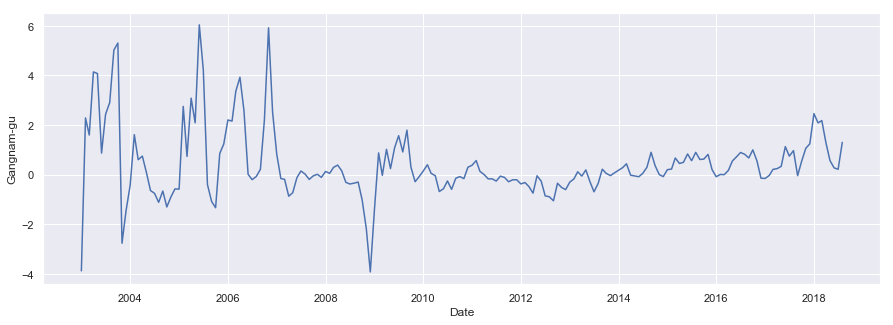

In [22]:
plt.figure(figsize = (15, 5))
ax = sns.lineplot(x="Date", y=GU_ENG_NAME, data=gangnam)

### Keras &  sklearn import

In [23]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import L1L2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Using TensorFlow backend.


In [24]:
gangnam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
Date          188 non-null datetime64[ns]
Gangnam-gu    188 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


In [25]:
mask = pd.to_datetime('2010-01-01')
tmp = gangnam.loc[:][gangnam['Date'] >= mask]

In [26]:
tmp

,Date,Gangnam-gu
84,2010-01-01,0.146998
85,2010-02-01,0.401215
86,2010-03-01,0.054086
87,2010-04-01,-0.042543
88,2010-05-01,-0.678413
89,2010-06-01,-0.567626
90,2010-07-01,-0.254231
91,2010-08-01,-0.591100
92,2010-09-01,-0.146213
93,2010-10-01,-0.075991


In [27]:
gangnam_tmp = tmp.drop('Date', 1)

In [28]:
gangnam_tmp

,Gangnam-gu
84,0.146998
85,0.401215
86,0.054086
87,-0.042543
88,-0.678413
89,-0.567626
90,-0.254231
91,-0.591100
92,-0.146213
93,-0.075991


### Normalize

In [29]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(gangnam_tmp)

In [30]:
dataset[:5]

array([[0.34161309],
       [0.41399694],
       [0.31515787],
       [0.28764442],
       [0.10659095]])

In [31]:
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (83, 21)


In [32]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [33]:
window_size = 4

In [34]:
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

whole_X, whole_Y = create_dataset(dataset, window_size)
print("Original training data shape:")
print(whole_X.shape)
print(whole_Y.shape)

Original training data shape:
(99, 4)
(99,)


### LSTM cross validation

In [36]:
X, y = create_dataset(dataset, window_size)

In [38]:
X[:5]

array([[0.34161309, 0.41399694, 0.31515787, 0.28764442],
       [0.41399694, 0.31515787, 0.28764442, 0.10659095],
       [0.31515787, 0.28764442, 0.10659095, 0.13813561],
       [0.28764442, 0.10659095, 0.13813561, 0.22736977],
       [0.10659095, 0.13813561, 0.22736977, 0.13145184]])

In [39]:
y[:5]

array([0.10659095, 0.13813561, 0.22736977, 0.13145184, 0.25812596])

In [40]:
from sklearn.model_selection import TimeSeriesSplit

In [50]:
tscv = TimeSeriesSplit(n_splits=10)

TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [ 9 10 11 12 13 14 15 16 17]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 9 samples, validate on 9 samples
Epoch 1/2000
9/9 [==============================] - 2s 245ms/step - loss: 5.1858 - val_loss: 5.1827

Epoch 00001: val_loss improved from inf to 5.18273, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.182728.hdf5
Epoch 2/2000
9/9 [==============================] - 0s 3ms/step - loss: 5.1591 - val_loss: 5.1522

Epoch 00002: val_loss improved from 5.18273 to 5.15216, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_l

Epoch 35/2000
9/9 [==============================] - 0s 3ms/step - loss: 4.3814 - val_loss: 4.3582

Epoch 00035: val_loss improved from 4.37901 to 4.35818, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-4.358185.hdf5
Epoch 36/2000
9/9 [==============================] - 0s 3ms/step - loss: 4.3605 - val_loss: 4.3374

Epoch 00036: val_loss improved from 4.35818 to 4.33736, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-4.337361.hdf5
Epoch 37/2000
9/9 [==============================] - 0s 3ms/step - loss: 4.3396 - val_loss: 4.3167

Epoch 00037: val_loss improved from 4.33736 to 4.31669, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-4.316692.hdf5
Epoch 38/2000
9/9 [==============================] - 0s 3ms/step - loss: 4.3189 - val_loss: 4.2960

Epoch 00038: val_loss improved from 4.31669 to 4.29597, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-4.295968.hdf5
Epoch 39/2000
9/9 [==============================] - 0s 3ms/step - loss: 4.2981 - val_loss: 4.2754

Epoc

Epoch 72/2000
9/9 [==============================] - 0s 3ms/step - loss: 3.6505 - val_loss: 3.6306

Epoch 00072: val_loss improved from 3.64918 to 3.63059, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.630589.hdf5
Epoch 73/2000
9/9 [==============================] - 0s 2ms/step - loss: 3.6319 - val_loss: 3.6121

Epoch 00073: val_loss improved from 3.63059 to 3.61214, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.612140.hdf5
Epoch 74/2000
9/9 [==============================] - 0s 2ms/step - loss: 3.6135 - val_loss: 3.5936

Epoch 00074: val_loss improved from 3.61214 to 3.59364, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.593639.hdf5
Epoch 75/2000
9/9 [==============================] - 0s 3ms/step - loss: 3.5949 - val_loss: 3.5753

Epoch 00075: val_loss improved from 3.59364 to 3.57531, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.575313.hdf5
Epoch 76/2000
9/9 [==============================] - 0s 3ms/step - loss: 3.5766 - val_loss: 3.5569

Epoc

Epoch 00108: val_loss improved from 3.01795 to 3.00143, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.001428.hdf5
Epoch 109/2000
9/9 [==============================] - 0s 3ms/step - loss: 3.0023 - val_loss: 2.9851

Epoch 00109: val_loss improved from 3.00143 to 2.98506, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.985060.hdf5
Epoch 110/2000
9/9 [==============================] - 0s 2ms/step - loss: 2.9860 - val_loss: 2.9687

Epoch 00110: val_loss improved from 2.98506 to 2.96866, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.968655.hdf5
Epoch 111/2000
9/9 [==============================] - 0s 4ms/step - loss: 2.9695 - val_loss: 2.9524

Epoch 00111: val_loss improved from 2.96866 to 2.95238, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.952378.hdf5
Epoch 112/2000
9/9 [==============================] - 0s 3ms/step - loss: 2.9533 - val_loss: 2.9361

Epoch 00112: val_loss improved from 2.95238 to 2.93614, saving model to ./TimeSeries/LSTM/Gangnam-gu

Epoch 145/2000
9/9 [==============================] - 0s 4ms/step - loss: 2.4453 - val_loss: 2.4304

Epoch 00145: val_loss improved from 2.44483 to 2.43044, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.430441.hdf5
Epoch 146/2000
9/9 [==============================] - 0s 3ms/step - loss: 2.4309 - val_loss: 2.4160

Epoch 00146: val_loss improved from 2.43044 to 2.41596, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.415963.hdf5
Epoch 147/2000
9/9 [==============================] - 0s 4ms/step - loss: 2.4164 - val_loss: 2.4016

Epoch 00147: val_loss improved from 2.41596 to 2.40158, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.401580.hdf5
Epoch 148/2000
9/9 [==============================] - 0s 3ms/step - loss: 2.4021 - val_loss: 2.3873

Epoch 00148: val_loss improved from 2.40158 to 2.38726, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.387256.hdf5
Epoch 149/2000
9/9 [==============================] - 0s 3ms/step - loss: 2.3877 - val_loss: 2.3730



Epoch 00181: val_loss improved from 1.95533 to 1.94267, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.942672.hdf5
Epoch 182/2000
9/9 [==============================] - 0s 4ms/step - loss: 1.9428 - val_loss: 1.9300

Epoch 00182: val_loss improved from 1.94267 to 1.93000, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.929998.hdf5
Epoch 183/2000
9/9 [==============================] - 0s 3ms/step - loss: 1.9301 - val_loss: 1.9174

Epoch 00183: val_loss improved from 1.93000 to 1.91741, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.917411.hdf5
Epoch 184/2000
9/9 [==============================] - 0s 4ms/step - loss: 1.9175 - val_loss: 1.9048

Epoch 00184: val_loss improved from 1.91741 to 1.90481, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.904815.hdf5
Epoch 185/2000
9/9 [==============================] - 0s 4ms/step - loss: 1.9049 - val_loss: 1.8924

Epoch 00185: val_loss improved from 1.90481 to 1.89235, saving model to ./TimeSeries/LSTM/Gangnam-g

Epoch 218/2000
9/9 [==============================] - 0s 3ms/step - loss: 1.5161 - val_loss: 1.5053

Epoch 00218: val_loss improved from 1.51634 to 1.50529, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.505286.hdf5
Epoch 219/2000
9/9 [==============================] - 0s 3ms/step - loss: 1.5050 - val_loss: 1.4943

Epoch 00219: val_loss improved from 1.50529 to 1.49430, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.494301.hdf5
Epoch 220/2000
9/9 [==============================] - 0s 4ms/step - loss: 1.4940 - val_loss: 1.4834

Epoch 00220: val_loss improved from 1.49430 to 1.48337, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.483374.hdf5
Epoch 221/2000
9/9 [==============================] - 0s 4ms/step - loss: 1.4830 - val_loss: 1.4725

Epoch 00221: val_loss improved from 1.48337 to 1.47248, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.472475.hdf5
Epoch 222/2000
9/9 [==============================] - 0s 4ms/step - loss: 1.4722 - val_loss: 1.4616



Epoch 00254: val_loss improved from 1.14596 to 1.13637, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.136367.hdf5
Epoch 255/2000
9/9 [==============================] - 0s 3ms/step - loss: 1.1357 - val_loss: 1.1269

Epoch 00255: val_loss improved from 1.13637 to 1.12688, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.126878.hdf5
Epoch 256/2000
9/9 [==============================] - 0s 3ms/step - loss: 1.1262 - val_loss: 1.1174

Epoch 00256: val_loss improved from 1.12688 to 1.11741, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.117411.hdf5
Epoch 257/2000
9/9 [==============================] - 0s 4ms/step - loss: 1.1167 - val_loss: 1.1080

Epoch 00257: val_loss improved from 1.11741 to 1.10804, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.108035.hdf5
Epoch 258/2000
9/9 [==============================] - 0s 4ms/step - loss: 1.1073 - val_loss: 1.0986

Epoch 00258: val_loss improved from 1.10804 to 1.09859, saving model to ./TimeSeries/LSTM/Gangnam-g

Epoch 291/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.8173 - val_loss: 0.8103

Epoch 00291: val_loss improved from 0.81840 to 0.81027, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.810270.hdf5
Epoch 292/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.8092 - val_loss: 0.8022

Epoch 00292: val_loss improved from 0.81027 to 0.80218, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.802181.hdf5
Epoch 293/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.8010 - val_loss: 0.7941

Epoch 00293: val_loss improved from 0.80218 to 0.79415, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.794148.hdf5
Epoch 294/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.7930 - val_loss: 0.7861

Epoch 00294: val_loss improved from 0.79415 to 0.78609, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.786087.hdf5
Epoch 295/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.7849 - val_loss: 0.7781



Epoch 00327: val_loss improved from 0.54824 to 0.54139, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.541391.hdf5
Epoch 328/2000
9/9 [==============================] - 0s 4ms/step - loss: 0.5397 - val_loss: 0.5346

Epoch 00328: val_loss improved from 0.54139 to 0.53457, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.534566.hdf5
Epoch 329/2000
9/9 [==============================] - 0s 5ms/step - loss: 0.5328 - val_loss: 0.5278

Epoch 00329: val_loss improved from 0.53457 to 0.52779, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.527786.hdf5
Epoch 330/2000
9/9 [==============================] - 0s 4ms/step - loss: 0.5260 - val_loss: 0.5210

Epoch 00330: val_loss improved from 0.52779 to 0.52101, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.521013.hdf5
Epoch 331/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.5192 - val_loss: 0.5143

Epoch 00331: val_loss improved from 0.52101 to 0.51430, saving model to ./TimeSeries/LSTM/Gangnam-g

Epoch 364/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.3137 - val_loss: 0.3105

Epoch 00364: val_loss improved from 0.31619 to 0.31047, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.310467.hdf5
Epoch 365/2000
9/9 [==============================] - 0s 4ms/step - loss: 0.3080 - val_loss: 0.3049

Epoch 00365: val_loss improved from 0.31047 to 0.30489, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.304895.hdf5
Epoch 366/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.3023 - val_loss: 0.2992

Epoch 00366: val_loss improved from 0.30489 to 0.29924, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.299242.hdf5
Epoch 367/2000
9/9 [==============================] - 0s 4ms/step - loss: 0.2966 - val_loss: 0.2937

Epoch 00367: val_loss improved from 0.29924 to 0.29370, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.293699.hdf5
Epoch 368/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.2911 - val_loss: 0.2881



Epoch 00400: val_loss improved from 0.12986 to 0.12519, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.125189.hdf5
Epoch 401/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.1216 - val_loss: 0.1206

Epoch 00401: val_loss improved from 0.12519 to 0.12055, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.120554.hdf5
Epoch 402/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.1170 - val_loss: 0.1159

Epoch 00402: val_loss improved from 0.12055 to 0.11589, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.115892.hdf5
Epoch 403/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.1123 - val_loss: 0.1114

Epoch 00403: val_loss improved from 0.11589 to 0.11137, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.111369.hdf5
Epoch 404/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.1078 - val_loss: 0.1067

Epoch 00404: val_loss improved from 0.11137 to 0.10673, saving model to ./TimeSeries/LSTM/Gangnam-g

9/9 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0072

Epoch 00440: val_loss did not improve from 0.00694
Epoch 441/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0070

Epoch 00441: val_loss did not improve from 0.00694
Epoch 442/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0073

Epoch 00442: val_loss did not improve from 0.00694
Epoch 443/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0070

Epoch 00443: val_loss did not improve from 0.00694
Epoch 444/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0071

Epoch 00444: val_loss did not improve from 0.00694
Epoch 445/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0073

Epoch 00445: val_loss did not improve from 0.00694
Epoch 446/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0073

Ep

9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0083

Epoch 00494: val_loss did not improve from 0.00694
Epoch 495/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0083

Epoch 00495: val_loss did not improve from 0.00694
Epoch 496/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0086

Epoch 00496: val_loss did not improve from 0.00694
Epoch 497/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0085

Epoch 00497: val_loss did not improve from 0.00694
Epoch 498/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0086

Epoch 00498: val_loss did not improve from 0.00694
Epoch 499/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0087

Epoch 00499: val_loss did not improve from 0.00694
Epoch 500/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0085

Ep

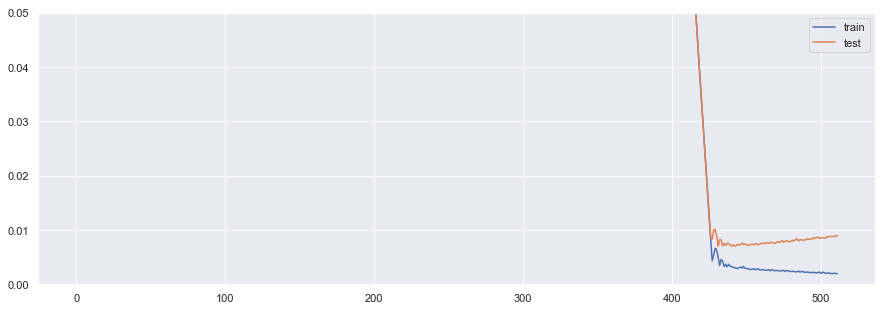

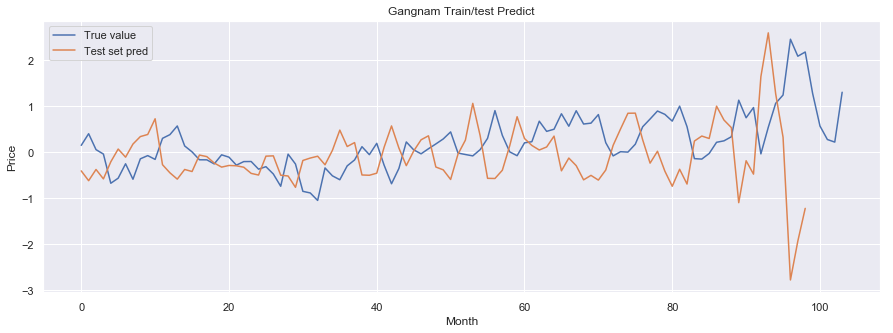

len before:  99
X shape:  (99,)
trans:  [ 0.32398647 -2.7846396  -1.938359   -1.2255561 ]
type:  <class 'numpy.ndarray'>
trans:  [[ 0.32398647]
 [-2.7846396 ]
 [-1.938359  ]
 [-1.2255561 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[ 0.32398647 -2.7846396  -1.938359   -1.2255561 ]]]
pred:  [[-0.01019806]]
future_pred
[-0.01019806]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[-2.7846396  -1.938359   -1.2255561  -0.01019806]]
type:  <class 'numpy.ndarray'>
trans:  [[-2.7846396 ]
 [-1.938359  ]
 [-1.2255561 ]
 [-0.01019806]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[-2.7846396  -1.938359   -1.2255561  -0.01019806]]]
pred:  [[0.02280693]]
future_pred
[0.02280693]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[-1.938359   -1.2255561  -0.01019806  0.02280693]]
type:  <class 'numpy.ndarray'>
trans:  [[-1.938359  ]
 [-1.2255561 ]
 [-0.01019806]
 [ 0.02280693]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1

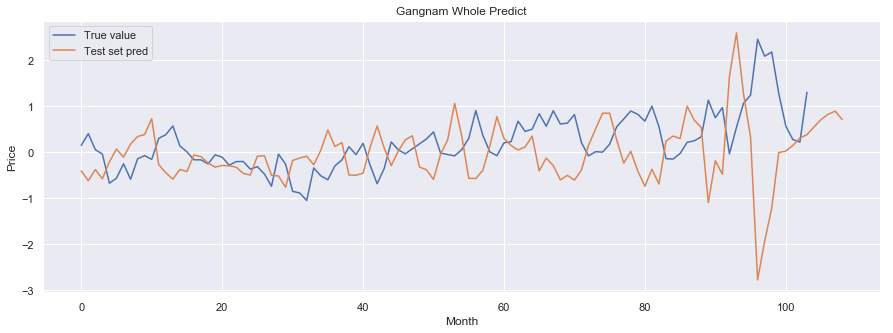

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18 19 20 21 22 23 24 25 26]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 18 samples, validate on 9 samples
Epoch 1/2000
18/18 [==============================] - 2s 135ms/step - loss: 5.1810 - val_loss: 5.1201

Epoch 00001: val_loss improved from inf to 5.12011, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.120110.hdf5
Epoch 2/2000
18/18 [==============================] - 0s 2ms/step - loss: 5.1341 - val_loss: 5.0771

Epoch 00002: val_loss improved from 5.12011 to 5.07711, saving model to ./TimeSeries/LSTM/Gangnam-gu/

18/18 [==============================] - 0s 2ms/step - loss: 3.9467 - val_loss: 3.9235

Epoch 00034: val_loss improved from 3.95604 to 3.92347, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.923475.hdf5
Epoch 35/2000
18/18 [==============================] - 0s 2ms/step - loss: 3.9142 - val_loss: 3.8912

Epoch 00035: val_loss improved from 3.92347 to 3.89120, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.891199.hdf5
Epoch 36/2000
18/18 [==============================] - 0s 2ms/step - loss: 3.8818 - val_loss: 3.8591

Epoch 00036: val_loss improved from 3.89120 to 3.85913, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.859132.hdf5
Epoch 37/2000
18/18 [==============================] - 0s 2ms/step - loss: 3.8497 - val_loss: 3.8271

Epoch 00037: val_loss improved from 3.85913 to 3.82714, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.827142.hdf5
Epoch 38/2000
18/18 [==============================] - 0s 2ms/step - loss: 3.8177 - val_loss: 3.7954

Epoch 00

18/18 [==============================] - 0s 2ms/step - loss: 2.8816 - val_loss: 2.8651

Epoch 00070: val_loss improved from 2.89176 to 2.86512, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.865124.hdf5
Epoch 71/2000
18/18 [==============================] - 0s 2ms/step - loss: 2.8550 - val_loss: 2.8387

Epoch 00071: val_loss improved from 2.86512 to 2.83871, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.838712.hdf5
Epoch 72/2000
18/18 [==============================] - 0s 2ms/step - loss: 2.8285 - val_loss: 2.8124

Epoch 00072: val_loss improved from 2.83871 to 2.81239, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.812386.hdf5
Epoch 73/2000
18/18 [==============================] - 0s 2ms/step - loss: 2.8022 - val_loss: 2.7862

Epoch 00073: val_loss improved from 2.81239 to 2.78623, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.786234.hdf5
Epoch 74/2000
18/18 [==============================] - 0s 2ms/step - loss: 2.7760 - val_loss: 2.7602

Epoch 00

18/18 [==============================] - 0s 2ms/step - loss: 2.0148 - val_loss: 2.0040

Epoch 00106: val_loss improved from 2.02549 to 2.00398, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.003983.hdf5
Epoch 107/2000
18/18 [==============================] - 0s 3ms/step - loss: 1.9933 - val_loss: 1.9826

Epoch 00107: val_loss improved from 2.00398 to 1.98259, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.982585.hdf5
Epoch 108/2000
18/18 [==============================] - 0s 3ms/step - loss: 1.9719 - val_loss: 1.9614

Epoch 00108: val_loss improved from 1.98259 to 1.96139, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.961387.hdf5
Epoch 109/2000
18/18 [==============================] - 0s 2ms/step - loss: 1.9507 - val_loss: 1.9403

Epoch 00109: val_loss improved from 1.96139 to 1.94029, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.940290.hdf5
Epoch 110/2000
18/18 [==============================] - 0s 2ms/step - loss: 1.9295 - val_loss: 1.9193

Epoc

18/18 [==============================] - 0s 2ms/step - loss: 1.3204 - val_loss: 1.3138

Epoch 00142: val_loss improved from 1.33084 to 1.31377, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.313770.hdf5
Epoch 143/2000
18/18 [==============================] - 0s 2ms/step - loss: 1.3033 - val_loss: 1.2968

Epoch 00143: val_loss improved from 1.31377 to 1.29679, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.296787.hdf5
Epoch 144/2000
18/18 [==============================] - 0s 2ms/step - loss: 1.2864 - val_loss: 1.2799

Epoch 00144: val_loss improved from 1.29679 to 1.27992, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.279920.hdf5
Epoch 145/2000
18/18 [==============================] - 0s 2ms/step - loss: 1.2696 - val_loss: 1.2632

Epoch 00145: val_loss improved from 1.27992 to 1.26322, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.263218.hdf5
Epoch 146/2000
18/18 [==============================] - 0s 2ms/step - loss: 1.2528 - val_loss: 1.2466

Epoc

18/18 [==============================] - 0s 2ms/step - loss: 0.7747 - val_loss: 0.7711

Epoch 00178: val_loss improved from 0.78439 to 0.77110, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.771099.hdf5
Epoch 179/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.7614 - val_loss: 0.7580

Epoch 00179: val_loss improved from 0.77110 to 0.75799, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.757987.hdf5
Epoch 180/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.7483 - val_loss: 0.7449

Epoch 00180: val_loss improved from 0.75799 to 0.74494, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.744940.hdf5
Epoch 181/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.7353 - val_loss: 0.7320

Epoch 00181: val_loss improved from 0.74494 to 0.73204, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.732036.hdf5
Epoch 182/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.7224 - val_loss: 0.7192

Epoc

18/18 [==============================] - 0s 2ms/step - loss: 0.3595 - val_loss: 0.3586

Epoch 00214: val_loss improved from 0.36848 to 0.35860, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.358602.hdf5
Epoch 215/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.3497 - val_loss: 0.3488

Epoch 00215: val_loss improved from 0.35860 to 0.34880, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.348802.hdf5
Epoch 216/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.3399 - val_loss: 0.3391

Epoch 00216: val_loss improved from 0.34880 to 0.33913, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.339134.hdf5
Epoch 217/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.3302 - val_loss: 0.3295

Epoch 00217: val_loss improved from 0.33913 to 0.32949, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.329491.hdf5
Epoch 218/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.3206 - val_loss: 0.3200

Epoc

18/18 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0558

Epoch 00250: val_loss improved from 0.06293 to 0.05584, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.055835.hdf5
Epoch 251/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0488

Epoch 00251: val_loss improved from 0.05584 to 0.04878, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.048778.hdf5
Epoch 252/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0418

Epoch 00252: val_loss improved from 0.04878 to 0.04178, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.041779.hdf5
Epoch 253/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0349

Epoch 00253: val_loss improved from 0.04178 to 0.03486, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.034859.hdf5
Epoch 254/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0280

Epoc

18/18 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0105

Epoch 00296: val_loss did not improve from 0.01031
Epoch 297/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0104

Epoch 00297: val_loss did not improve from 0.01031
Epoch 298/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0105

Epoch 00298: val_loss did not improve from 0.01031
Epoch 299/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0105

Epoch 00299: val_loss did not improve from 0.01031
Epoch 300/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0104

Epoch 00300: val_loss did not improve from 0.01031
Epoch 301/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0104

Epoch 00301: val_loss did not improve from 0.01031
Epoch 302/2000
18/18 [==============================] - 0s 2ms/step - loss: 0.0043 - val_lo

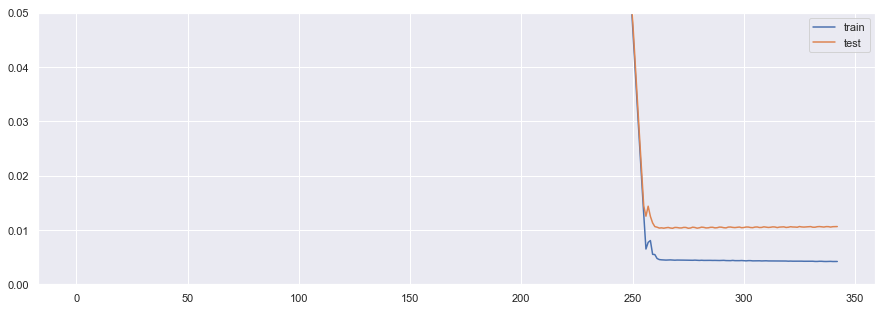

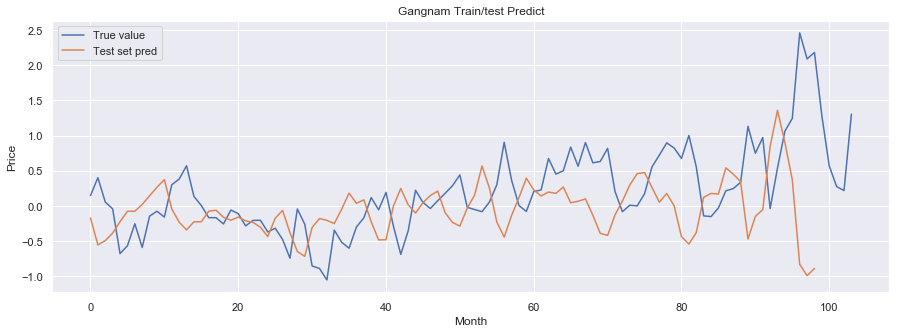

len before:  99
X shape:  (99,)
trans:  [ 0.36955702 -0.83103836 -0.9918904  -0.88940436]
type:  <class 'numpy.ndarray'>
trans:  [[ 0.36955702]
 [-0.83103836]
 [-0.9918904 ]
 [-0.88940436]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[ 0.36955702 -0.83103836 -0.9918904  -0.88940436]]]
pred:  [[0.08819902]]
future_pred
[0.08819902]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[-0.83103836 -0.9918904  -0.88940436  0.08819902]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.83103836]
 [-0.9918904 ]
 [-0.88940436]
 [ 0.08819902]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[-0.83103836 -0.9918904  -0.88940436  0.08819902]]]
pred:  [[0.0815183]]
future_pred
[0.0815183]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[-0.9918904  -0.88940436  0.08819902  0.0815183 ]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.9918904 ]
 [-0.88940436]
 [ 0.08819902]
 [ 0.0815183 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1

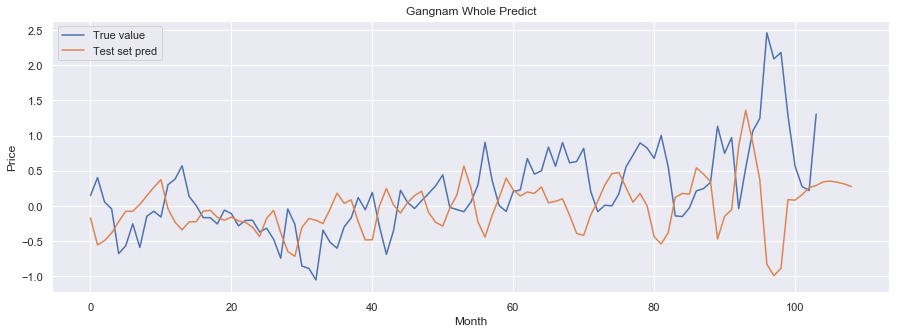

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33 34 35]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 27 samples, validate on 9 samples
Epoch 1/2000
27/27 [==============================] - 3s 95ms/step - loss: 5.1652 - val_loss: 5.1075

Epoch 00001: val_loss improved from inf to 5.10752, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.107517.hdf5
Epoch 2/2000
27/27 [==============================] - 0s 2ms/step - loss: 5.0992 - val_loss: 5.0488

Epoch 00002: val_loss improved from 5.10752 to 5.04885, saving model to ./TimeSeries/LSTM/Gangnam-gu/v

27/27 [==============================] - 0s 2ms/step - loss: 3.5234 - val_loss: 3.5004

Epoch 00034: val_loss improved from 3.54281 to 3.50040, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.500402.hdf5
Epoch 35/2000
27/27 [==============================] - 0s 2ms/step - loss: 3.4812 - val_loss: 3.4585

Epoch 00035: val_loss improved from 3.50040 to 3.45846, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.458457.hdf5
Epoch 36/2000
27/27 [==============================] - 0s 2ms/step - loss: 3.4393 - val_loss: 3.4167

Epoch 00036: val_loss improved from 3.45846 to 3.41671, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.416715.hdf5
Epoch 37/2000
27/27 [==============================] - 0s 2ms/step - loss: 3.3977 - val_loss: 3.3753

Epoch 00037: val_loss improved from 3.41671 to 3.37526, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.375258.hdf5
Epoch 38/2000
27/27 [==============================] - 0s 2ms/step - loss: 3.3565 - val_loss: 3.3341

Epoch 00

27/27 [==============================] - 0s 2ms/step - loss: 2.1959 - val_loss: 2.1787

Epoch 00070: val_loss improved from 2.21046 to 2.17872, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.178719.hdf5
Epoch 71/2000
27/27 [==============================] - 0s 2ms/step - loss: 2.1643 - val_loss: 2.1473

Epoch 00071: val_loss improved from 2.17872 to 2.14733, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.147331.hdf5
Epoch 72/2000
27/27 [==============================] - 0s 3ms/step - loss: 2.1329 - val_loss: 2.1161

Epoch 00072: val_loss improved from 2.14733 to 2.11612, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.116123.hdf5
Epoch 73/2000
27/27 [==============================] - 0s 3ms/step - loss: 2.1019 - val_loss: 2.0852

Epoch 00073: val_loss improved from 2.11612 to 2.08518, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.085176.hdf5
Epoch 74/2000
27/27 [==============================] - 0s 2ms/step - loss: 2.0711 - val_loss: 2.0545

Epoch 00

27/27 [==============================] - 0s 2ms/step - loss: 1.2166 - val_loss: 1.2045

Epoch 00106: val_loss improved from 1.22748 to 1.20452, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.204523.hdf5
Epoch 107/2000
27/27 [==============================] - 0s 3ms/step - loss: 1.1937 - val_loss: 1.1818

Epoch 00107: val_loss improved from 1.20452 to 1.18182, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.181817.hdf5
Epoch 108/2000
27/27 [==============================] - 0s 4ms/step - loss: 1.1710 - val_loss: 1.1592

Epoch 00108: val_loss improved from 1.18182 to 1.15925, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.159248.hdf5
Epoch 109/2000
27/27 [==============================] - 0s 3ms/step - loss: 1.1486 - val_loss: 1.1369

Epoch 00109: val_loss improved from 1.15925 to 1.13689, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.136888.hdf5
Epoch 110/2000
27/27 [==============================] - 0s 3ms/step - loss: 1.1264 - val_loss: 1.1148

Epoc

27/27 [==============================] - 0s 2ms/step - loss: 0.5226 - val_loss: 0.5151

Epoch 00142: val_loss improved from 0.53081 to 0.51514, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.515136.hdf5
Epoch 143/2000
27/27 [==============================] - 0s 2ms/step - loss: 0.5069 - val_loss: 0.4996

Epoch 00143: val_loss improved from 0.51514 to 0.49959, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.499588.hdf5
Epoch 144/2000
27/27 [==============================] - 0s 5ms/step - loss: 0.4914 - val_loss: 0.4841

Epoch 00144: val_loss improved from 0.49959 to 0.48415, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.484148.hdf5
Epoch 145/2000
27/27 [==============================] - 0s 2ms/step - loss: 0.4761 - val_loss: 0.4690

Epoch 00145: val_loss improved from 0.48415 to 0.46895, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.468953.hdf5
Epoch 146/2000
27/27 [==============================] - 0s 2ms/step - loss: 0.4610 - val_loss: 0.4539

Epoc

27/27 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0587

Epoch 00178: val_loss improved from 0.06880 to 0.05874, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.058739.hdf5
Epoch 179/2000
27/27 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0488

Epoch 00179: val_loss improved from 0.05874 to 0.04881, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.048814.hdf5
Epoch 180/2000
27/27 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0390

Epoch 00180: val_loss improved from 0.04881 to 0.03898, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.038978.hdf5
Epoch 181/2000
27/27 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0293

Epoch 00181: val_loss improved from 0.03898 to 0.02926, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.029256.hdf5
Epoch 182/2000
27/27 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0197

Epoc


Epoch 00225: val_loss did not improve from 0.00812
Epoch 226/2000
27/27 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0089

Epoch 00226: val_loss did not improve from 0.00812
Epoch 227/2000
27/27 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0084

Epoch 00227: val_loss did not improve from 0.00812
Epoch 228/2000
27/27 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0088

Epoch 00228: val_loss did not improve from 0.00812
Epoch 229/2000
27/27 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0089

Epoch 00229: val_loss did not improve from 0.00812
Epoch 230/2000
27/27 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0087

Epoch 00230: val_loss did not improve from 0.00812
Epoch 231/2000
27/27 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0089

Epoch 00231: val_loss did not improve from 0.00812
Epoch 232/2000
27/27 [==

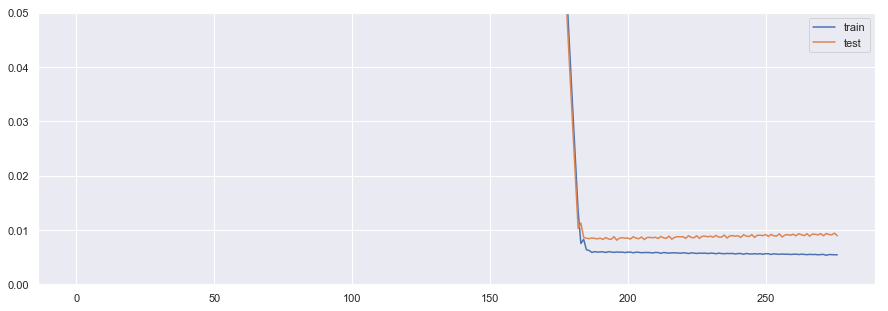

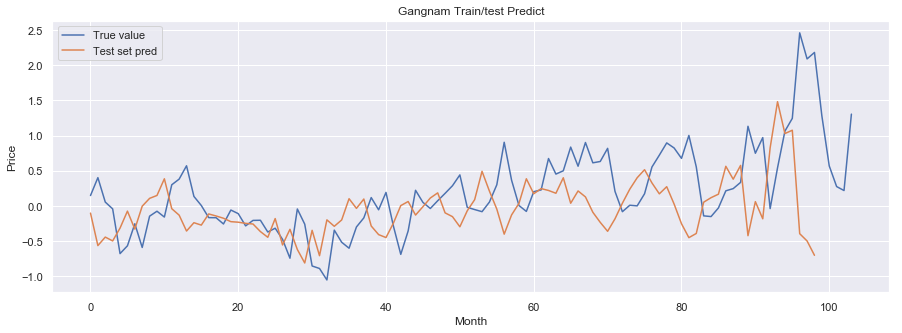

len before:  99
X shape:  (99,)
trans:  [ 1.0753232  -0.39517057 -0.49874896 -0.7024234 ]
type:  <class 'numpy.ndarray'>
trans:  [[ 1.0753232 ]
 [-0.39517057]
 [-0.49874896]
 [-0.7024234 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[ 1.0753232  -0.39517057 -0.49874896 -0.7024234 ]]]
pred:  [[-0.31410536]]
future_pred
[-0.31410536]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[-0.39517057 -0.49874896 -0.7024234  -0.31410536]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.39517057]
 [-0.49874896]
 [-0.7024234 ]
 [-0.31410536]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[-0.39517057 -0.49874896 -0.7024234  -0.31410536]]]
pred:  [[0.05963701]]
future_pred
[0.05963701]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[-0.49874896 -0.7024234  -0.31410536  0.05963701]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.49874896]
 [-0.7024234 ]
 [-0.31410536]
 [ 0.05963701]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1

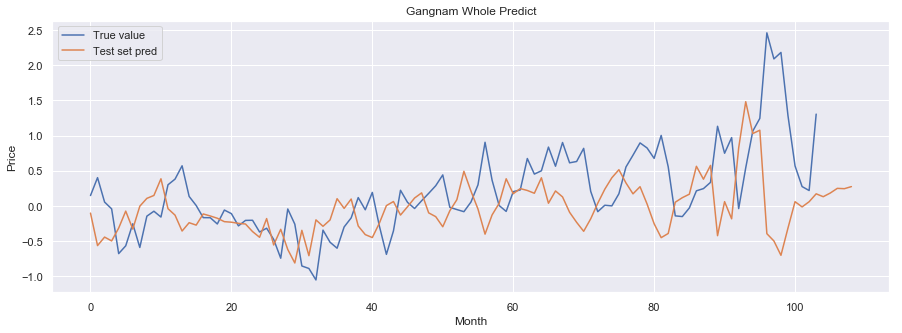

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] TEST: [36 37 38 39 40 41 42 43 44]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 36 samples, validate on 9 samples
Epoch 1/2000
36/36 [==============================] - 3s 79ms/step - loss: 5.1460 - val_loss: 5.1205

Epoch 00001: val_loss improved from inf to 5.12045, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.120454.hdf5
Epoch 2/2000
36/36 [==============================] - 0s 2ms/step - loss: 5.0665 - val_loss: 5.0370

Epoch 00002: val_loss improved from 5.12045 to 5.03697, saving model to ./TimeSeries/LSTM/Gangnam-gu/v

36/36 [==============================] - 0s 3ms/step - loss: 3.1315 - val_loss: 3.1055

Epoch 00034: val_loss improved from 3.15603 to 3.10549, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.105492.hdf5
Epoch 35/2000
36/36 [==============================] - 0s 2ms/step - loss: 3.0811 - val_loss: 3.0555

Epoch 00035: val_loss improved from 3.10549 to 3.05551, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.055506.hdf5
Epoch 36/2000
36/36 [==============================] - 0s 2ms/step - loss: 3.0313 - val_loss: 3.0061

Epoch 00036: val_loss improved from 3.05551 to 3.00611, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-3.006115.hdf5
Epoch 37/2000
36/36 [==============================] - 0s 2ms/step - loss: 2.9820 - val_loss: 2.9571

Epoch 00037: val_loss improved from 3.00611 to 2.95708, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.957083.hdf5
Epoch 38/2000
36/36 [==============================] - 0s 2ms/step - loss: 2.9332 - val_loss: 2.9086

Epoch 00

36/36 [==============================] - 0s 2ms/step - loss: 1.6164 - val_loss: 1.6004

Epoch 00070: val_loss improved from 1.63478 to 1.60044, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.600444.hdf5
Epoch 71/2000
36/36 [==============================] - 0s 2ms/step - loss: 1.5823 - val_loss: 1.5666

Epoch 00071: val_loss improved from 1.60044 to 1.56663, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.566634.hdf5
Epoch 72/2000
36/36 [==============================] - 0s 2ms/step - loss: 1.5486 - val_loss: 1.5332

Epoch 00072: val_loss improved from 1.56663 to 1.53320, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.533197.hdf5
Epoch 73/2000
36/36 [==============================] - 0s 2ms/step - loss: 1.5153 - val_loss: 1.5002

Epoch 00073: val_loss improved from 1.53320 to 1.50015, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.500153.hdf5
Epoch 74/2000
36/36 [==============================] - 0s 2ms/step - loss: 1.4824 - val_loss: 1.4674

Epoch 00

36/36 [==============================] - 0s 2ms/step - loss: 0.6177 - val_loss: 0.6092

Epoch 00106: val_loss improved from 0.63097 to 0.60925, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.609249.hdf5
Epoch 107/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.5962 - val_loss: 0.5880

Epoch 00107: val_loss improved from 0.60925 to 0.58801, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.588005.hdf5
Epoch 108/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.5750 - val_loss: 0.5670

Epoch 00108: val_loss improved from 0.58801 to 0.56702, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.567022.hdf5
Epoch 109/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.5541 - val_loss: 0.5463

Epoch 00109: val_loss improved from 0.56702 to 0.54631, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.546307.hdf5
Epoch 110/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.5335 - val_loss: 0.5258

Epoc

36/36 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0160

Epoch 00142: val_loss improved from 0.02835 to 0.01603, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.016034.hdf5
Epoch 143/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0126

Epoch 00143: val_loss improved from 0.01603 to 0.01263, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.012632.hdf5
Epoch 144/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0099

Epoch 00144: val_loss improved from 0.01263 to 0.00990, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.009905.hdf5
Epoch 145/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0103

Epoch 00145: val_loss did not improve from 0.00990
Epoch 146/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0098

Epoch 00146: val_loss improved from 0.00990 to 0.00980, saving model to ./Tim

36/36 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0106

Epoch 00193: val_loss did not improve from 0.00979
Epoch 194/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0106

Epoch 00194: val_loss did not improve from 0.00979
Epoch 195/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0106

Epoch 00195: val_loss did not improve from 0.00979
Epoch 196/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0108

Epoch 00196: val_loss did not improve from 0.00979
Epoch 197/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0106

Epoch 00197: val_loss did not improve from 0.00979
Epoch 198/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0105

Epoch 00198: val_loss did not improve from 0.00979
Epoch 199/2000
36/36 [==============================] - 0s 2ms/step - loss: 0.0049 - val_lo

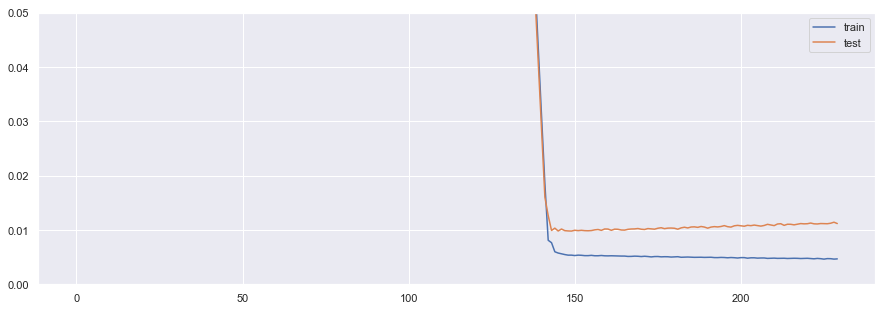

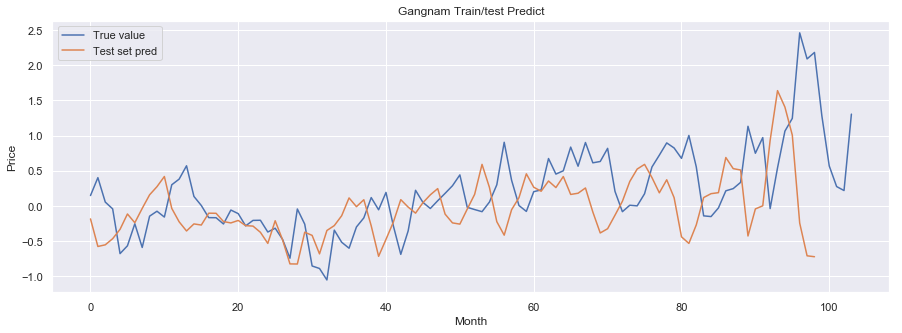

len before:  99
X shape:  (99,)
trans:  [ 1.0055083  -0.24405824 -0.7096133  -0.72274405]
type:  <class 'numpy.ndarray'>
trans:  [[ 1.0055083 ]
 [-0.24405824]
 [-0.7096133 ]
 [-0.72274405]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[ 1.0055083  -0.24405824 -0.7096133  -0.72274405]]]
pred:  [[1.1389952]]
future_pred
[1.1389952]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[-0.24405824 -0.7096133  -0.72274405  1.1389952 ]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.24405824]
 [-0.7096133 ]
 [-0.72274405]
 [ 1.1389952 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[-0.24405824 -0.7096133  -0.72274405  1.1389952 ]]]
pred:  [[-0.03726614]]
future_pred
[-0.03726614]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[-0.7096133  -0.72274405  1.1389952  -0.03726614]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.7096133 ]
 [-0.72274405]
 [ 1.1389952 ]
 [-0.03726614]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1: 

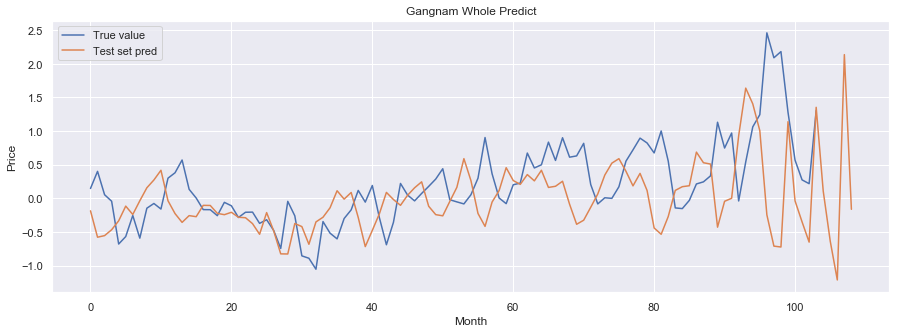

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] TEST: [45 46 47 48 49 50 51 52 53]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 45 samples, validate on 9 samples
Epoch 1/2000
45/45 [==============================] - 3s 65ms/step - loss: 5.1434 - val_loss: 5.1433

Epoch 00001: val_loss improved from inf to 5.14327, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.143274.hdf5
Epoch 2/2000
45/45 [==============================] - 0s 2ms/step - loss: 5.0361 - val_loss: 5.0212

Epoch 00002: val_loss improved from 5.14327 to 5.02124, saving model to ./TimeSeries/LSTM/Gangnam-gu/v

45/45 [==============================] - 0s 2ms/step - loss: 2.6008 - val_loss: 2.5692

Epoch 00034: val_loss improved from 2.62928 to 2.56923, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.569226.hdf5
Epoch 35/2000
45/45 [==============================] - 0s 2ms/step - loss: 2.5411 - val_loss: 2.5100

Epoch 00035: val_loss improved from 2.56923 to 2.50996, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.509957.hdf5
Epoch 36/2000
45/45 [==============================] - 0s 2ms/step - loss: 2.4822 - val_loss: 2.4515

Epoch 00036: val_loss improved from 2.50996 to 2.45154, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.451537.hdf5
Epoch 37/2000
45/45 [==============================] - 0s 2ms/step - loss: 2.4241 - val_loss: 2.3940

Epoch 00037: val_loss improved from 2.45154 to 2.39402, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.394018.hdf5
Epoch 38/2000
45/45 [==============================] - 0s 2ms/step - loss: 2.3669 - val_loss: 2.3372

Epoch 00

45/45 [==============================] - 0s 2ms/step - loss: 0.9243 - val_loss: 0.9076

Epoch 00070: val_loss improved from 0.94196 to 0.90755, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.907551.hdf5
Epoch 71/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.8901 - val_loss: 0.8737

Epoch 00071: val_loss improved from 0.90755 to 0.87369, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.873691.hdf5
Epoch 72/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.8565 - val_loss: 0.8405

Epoch 00072: val_loss improved from 0.87369 to 0.84048, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.840476.hdf5
Epoch 73/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.8235 - val_loss: 0.8077

Epoch 00073: val_loss improved from 0.84048 to 0.80771, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.807715.hdf5
Epoch 74/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.7911 - val_loss: 0.7757

Epoch 00

45/45 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0241

Epoch 00106: val_loss improved from 0.04065 to 0.02412, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.024119.hdf5
Epoch 107/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0107

Epoch 00107: val_loss improved from 0.02412 to 0.01069, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.010695.hdf5
Epoch 108/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0097

Epoch 00108: val_loss improved from 0.01069 to 0.00970, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.009698.hdf5
Epoch 109/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0099

Epoch 00109: val_loss did not improve from 0.00970
Epoch 110/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0096

Epoch 00110: val_loss improved from 0.00970 to 0.00958, saving model to ./Tim


Epoch 00154: val_loss did not improve from 0.00923
Epoch 155/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0094

Epoch 00155: val_loss did not improve from 0.00923
Epoch 156/2000
45/45 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0094

Epoch 00156: val_loss did not improve from 0.00923
Epoch 157/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0093

Epoch 00157: val_loss did not improve from 0.00923
Epoch 158/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0096

Epoch 00158: val_loss did not improve from 0.00923
Epoch 159/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0096

Epoch 00159: val_loss did not improve from 0.00923
Epoch 160/2000
45/45 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0093

Epoch 00160: val_loss did not improve from 0.00923
Epoch 161/2000
45/45 [==

45/45 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0092

Epoch 00205: val_loss did not improve from 0.00912
Epoch 206/2000
45/45 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0091

Epoch 00206: val_loss did not improve from 0.00912
Epoch 207/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0092

Epoch 00207: val_loss did not improve from 0.00912
Epoch 208/2000
45/45 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0092

Epoch 00208: val_loss did not improve from 0.00912
Epoch 209/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0092

Epoch 00209: val_loss did not improve from 0.00912
Epoch 210/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0092

Epoch 00210: val_loss did not improve from 0.00912
Epoch 211/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0054 - val_lo

45/45 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0091

Epoch 00258: val_loss did not improve from 0.00906
Epoch 259/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0091

Epoch 00259: val_loss did not improve from 0.00906
Epoch 260/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0092

Epoch 00260: val_loss did not improve from 0.00906
Epoch 261/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0091

Epoch 00261: val_loss improved from 0.00906 to 0.00906, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.009056.hdf5
Epoch 262/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0091

Epoch 00262: val_loss did not improve from 0.00906
Epoch 263/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0091

Epoch 00263: val_loss did not improve from 0.00906
Epoch 264/2000
45/

45/45 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0091

Epoch 00308: val_loss did not improve from 0.00896
Epoch 309/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0091

Epoch 00309: val_loss did not improve from 0.00896
Epoch 310/2000
45/45 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0092

Epoch 00310: val_loss did not improve from 0.00896
Epoch 311/2000
45/45 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0091

Epoch 00311: val_loss did not improve from 0.00896
Epoch 312/2000
45/45 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0091

Epoch 00312: val_loss did not improve from 0.00896
Epoch 313/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0091

Epoch 00313: val_loss did not improve from 0.00896
Epoch 314/2000
45/45 [==============================] - 0s 3ms/step - loss: 0.0045 - val_lo

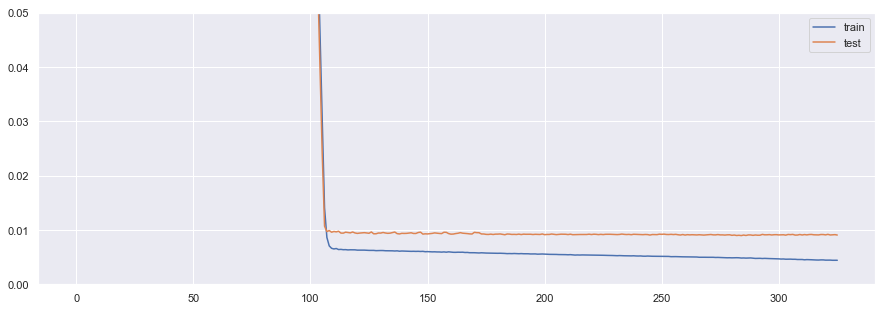

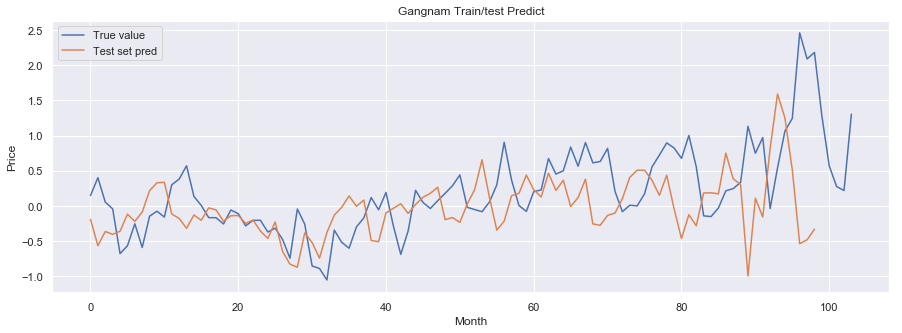

len before:  99
X shape:  (99,)
trans:  [ 0.511442   -0.537547   -0.4823396  -0.33147144]
type:  <class 'numpy.ndarray'>
trans:  [[ 0.511442  ]
 [-0.537547  ]
 [-0.4823396 ]
 [-0.33147144]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[ 0.511442   -0.537547   -0.4823396  -0.33147144]]]
pred:  [[0.165493]]
future_pred
[0.165493]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[-0.537547   -0.4823396  -0.33147144  0.165493  ]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.537547  ]
 [-0.4823396 ]
 [-0.33147144]
 [ 0.165493  ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[-0.537547   -0.4823396  -0.33147144  0.165493  ]]]
pred:  [[-0.0047024]]
future_pred
[-0.0047024]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[-0.4823396  -0.33147144  0.165493   -0.0047024 ]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.4823396 ]
 [-0.33147144]
 [ 0.165493  ]
 [-0.0047024 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
t

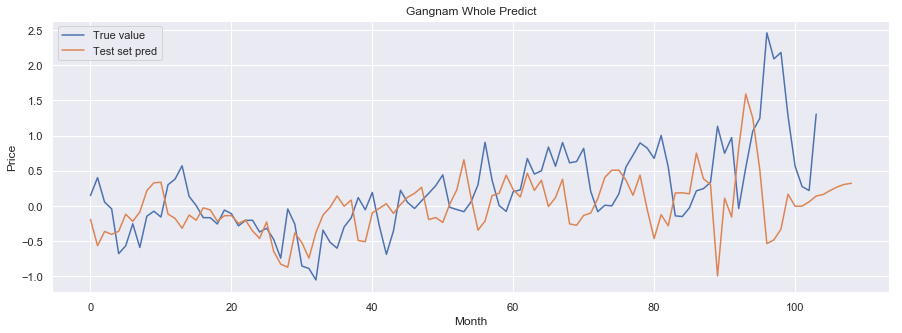

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53] TEST: [54 55 56 57 58 59 60 61 62]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 54 samples, validate on 9 samples
Epoch 1/2000
54/54 [==============================] - 3s 51ms/step - loss: 5.1443 - val_loss: 5.1407

Epoch 00001: val_loss improved from inf to 5.14066, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.140655.hdf5
Epoch 2/2000
54/54 [==============================] - 0s 2ms/step - loss: 5.0146 - val_loss: 4.9881

Epoch 00002: val_loss improved from 5.14066 to 4.98808, saving model to ./TimeSeries/LSTM/Gangnam-gu/v

54/54 [==============================] - 0s 3ms/step - loss: 2.2771 - val_loss: 2.2409

Epoch 00034: val_loss improved from 2.30561 to 2.24093, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.240930.hdf5
Epoch 35/2000
54/54 [==============================] - 0s 2ms/step - loss: 2.2129 - val_loss: 2.1772

Epoch 00035: val_loss improved from 2.24093 to 2.17723, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.177232.hdf5
Epoch 36/2000
54/54 [==============================] - 0s 2ms/step - loss: 2.1497 - val_loss: 2.1148

Epoch 00036: val_loss improved from 2.17723 to 2.11479, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.114786.hdf5
Epoch 37/2000
54/54 [==============================] - 0s 3ms/step - loss: 2.0876 - val_loss: 2.0532

Epoch 00037: val_loss improved from 2.11479 to 2.05319, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-2.053193.hdf5
Epoch 38/2000
54/54 [==============================] - 0s 4ms/step - loss: 2.0266 - val_loss: 1.9928

Epoch 00

54/54 [==============================] - 0s 2ms/step - loss: 0.5640 - val_loss: 0.5463

Epoch 00070: val_loss improved from 0.57868 to 0.54634, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.546336.hdf5
Epoch 71/2000
54/54 [==============================] - 0s 2ms/step - loss: 0.5319 - val_loss: 0.5147

Epoch 00071: val_loss improved from 0.54634 to 0.51470, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.514699.hdf5
Epoch 72/2000
54/54 [==============================] - 0s 2ms/step - loss: 0.5006 - val_loss: 0.4837

Epoch 00072: val_loss improved from 0.51470 to 0.48374, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.483743.hdf5
Epoch 73/2000
54/54 [==============================] - 0s 2ms/step - loss: 0.4700 - val_loss: 0.4535

Epoch 00073: val_loss improved from 0.48374 to 0.45349, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.453494.hdf5
Epoch 74/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.4401 - val_loss: 0.4241

Epoch 00

54/54 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0078

Epoch 00111: val_loss did not improve from 0.00752
Epoch 112/2000
54/54 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0076

Epoch 00112: val_loss did not improve from 0.00752
Epoch 113/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0078

Epoch 00113: val_loss did not improve from 0.00752
Epoch 114/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0078

Epoch 00114: val_loss did not improve from 0.00752
Epoch 115/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0077

Epoch 00115: val_loss did not improve from 0.00752
Epoch 116/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0079

Epoch 00116: val_loss did not improve from 0.00752
Epoch 117/2000
54/54 [==============================] - 0s 2ms/step - loss: 0.0070 - val_lo

54/54 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0081

Epoch 00164: val_loss did not improve from 0.00752
Epoch 165/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0081

Epoch 00165: val_loss did not improve from 0.00752
Epoch 166/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0081

Epoch 00166: val_loss did not improve from 0.00752
Epoch 167/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0081

Epoch 00167: val_loss did not improve from 0.00752
Epoch 168/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0081

Epoch 00168: val_loss did not improve from 0.00752
Epoch 169/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0081

Epoch 00169: val_loss did not improve from 0.00752
Epoch 170/2000
54/54 [==============================] - 0s 1ms/step - loss: 0.0066 - val_lo

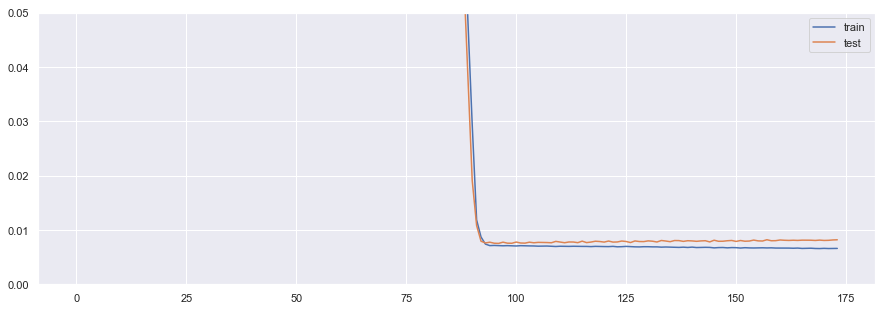

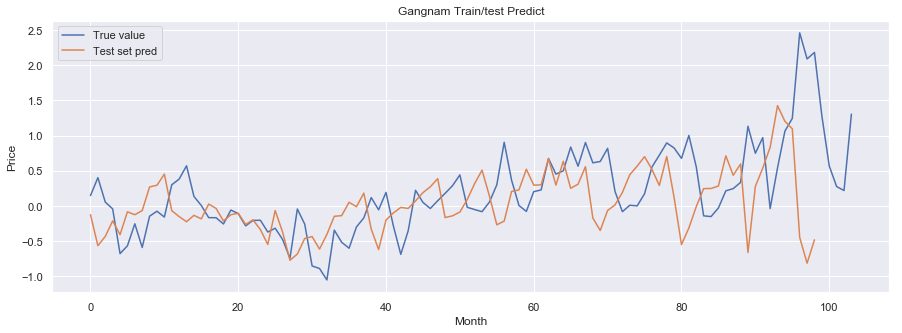

len before:  99
X shape:  (99,)
trans:  [ 1.0963277  -0.4483753  -0.81454784 -0.48203313]
type:  <class 'numpy.ndarray'>
trans:  [[ 1.0963277 ]
 [-0.4483753 ]
 [-0.81454784]
 [-0.48203313]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[ 1.0963277  -0.4483753  -0.81454784 -0.48203313]]]
pred:  [[0.52551246]]
future_pred
[0.52551246]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[-0.4483753  -0.81454784 -0.48203313  0.52551246]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.4483753 ]
 [-0.81454784]
 [-0.48203313]
 [ 0.52551246]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[-0.4483753  -0.81454784 -0.48203313  0.52551246]]]
pred:  [[-0.0649599]]
future_pred
[-0.0649599]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[-0.81454784 -0.48203313  0.52551246 -0.0649599 ]]
type:  <class 'numpy.ndarray'>
trans:  [[-0.81454784]
 [-0.48203313]
 [ 0.52551246]
 [-0.0649599 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1: 

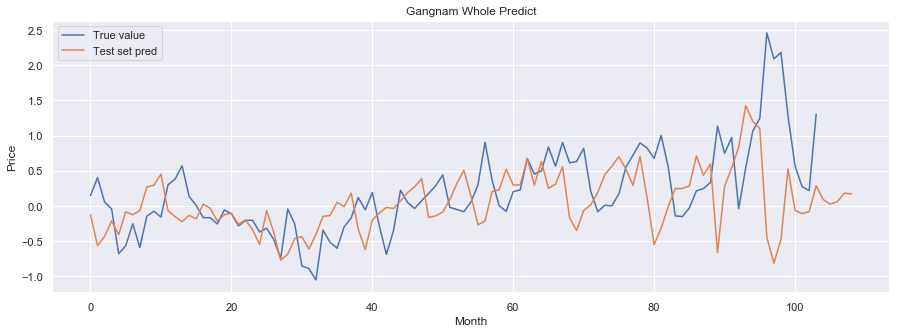

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62] TEST: [63 64 65 66 67 68 69 70 71]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 63 samples, validate on 9 samples
Epoch 1/2000
63/63 [==============================] - 4s 61ms/step - loss: 5.1327 - val_loss: 5.0886

Epoch 00001: val_loss improved from inf to 5.08865, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.088649.hdf5
Epoch 2/2000
63/63 [==============================] - 0s 2ms/step - loss: 4.9828 - val_loss: 4.9202

Epoch 00002: val_loss improved from 5.08865 to 4.92017, saving model to ./TimeSeries/LSTM/Gangnam-gu/v

63/63 [==============================] - 0s 3ms/step - loss: 1.9794 - val_loss: 1.9419

Epoch 00034: val_loss improved from 2.01005 to 1.94187, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.941872.hdf5
Epoch 35/2000
63/63 [==============================] - 0s 3ms/step - loss: 1.9119 - val_loss: 1.8750

Epoch 00035: val_loss improved from 1.94187 to 1.87502, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.875019.hdf5
Epoch 36/2000
63/63 [==============================] - 0s 3ms/step - loss: 1.8456 - val_loss: 1.8095

Epoch 00036: val_loss improved from 1.87502 to 1.80949, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.809494.hdf5
Epoch 37/2000
63/63 [==============================] - 0s 3ms/step - loss: 1.7807 - val_loss: 1.7453

Epoch 00037: val_loss improved from 1.80949 to 1.74534, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.745336.hdf5
Epoch 38/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.7171 - val_loss: 1.6824

Epoch 00

63/63 [==============================] - 0s 2ms/step - loss: 0.2769 - val_loss: 0.2608

Epoch 00070: val_loss improved from 0.29002 to 0.26076, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.260756.hdf5
Epoch 71/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.2480 - val_loss: 0.2324

Epoch 00071: val_loss improved from 0.26076 to 0.23237, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.232371.hdf5
Epoch 72/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.2200 - val_loss: 0.2048

Epoch 00072: val_loss improved from 0.23237 to 0.20477, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.204772.hdf5
Epoch 73/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.1927 - val_loss: 0.1779

Epoch 00073: val_loss improved from 0.20477 to 0.17793, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.177930.hdf5
Epoch 74/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.1662 - val_loss: 0.1519

Epoch 00

63/63 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0070

Epoch 00116: val_loss did not improve from 0.00684
Epoch 117/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0072

Epoch 00117: val_loss did not improve from 0.00684
Epoch 118/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0072

Epoch 00118: val_loss did not improve from 0.00684
Epoch 119/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0070

Epoch 00119: val_loss did not improve from 0.00684
Epoch 120/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0071

Epoch 00120: val_loss did not improve from 0.00684
Epoch 121/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0070

Epoch 00121: val_loss did not improve from 0.00684
Epoch 122/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.0068 - val_lo

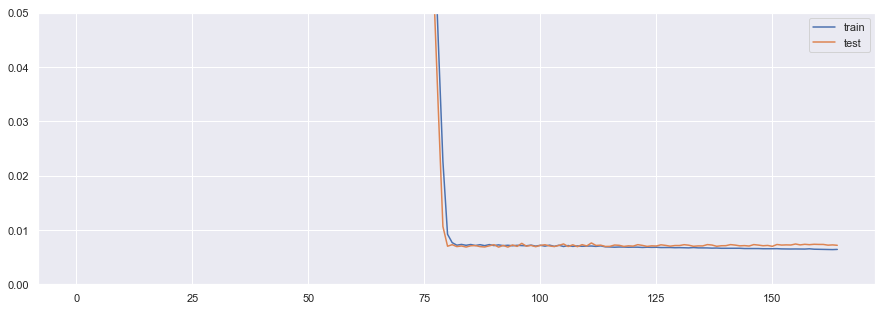

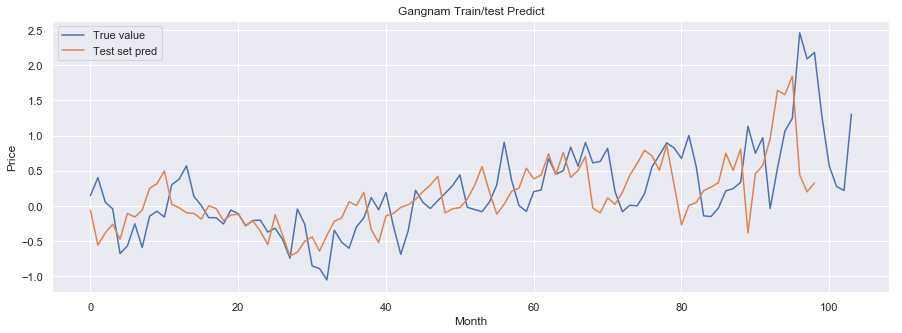

len before:  99
X shape:  (99,)
trans:  [1.8448118  0.44017074 0.19981962 0.32734692]
type:  <class 'numpy.ndarray'>
trans:  [[1.8448118 ]
 [0.44017074]
 [0.19981962]
 [0.32734692]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[1.8448118  0.44017074 0.19981962 0.32734692]]]
pred:  [[1.1547694]]
future_pred
[1.1547694]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[0.44017074 0.19981962 0.32734692 1.1547694 ]]
type:  <class 'numpy.ndarray'>
trans:  [[0.44017074]
 [0.19981962]
 [0.32734692]
 [1.1547694 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[0.44017074 0.19981962 0.32734692 1.1547694 ]]]
pred:  [[0.4463029]]
future_pred
[0.4463029]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[0.19981962 0.32734692 1.1547694  0.4463029 ]]
type:  <class 'numpy.ndarray'>
trans:  [[0.19981962]
 [0.32734692]
 [1.1547694 ]
 [0.4463029 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[0.19981962 0.32734

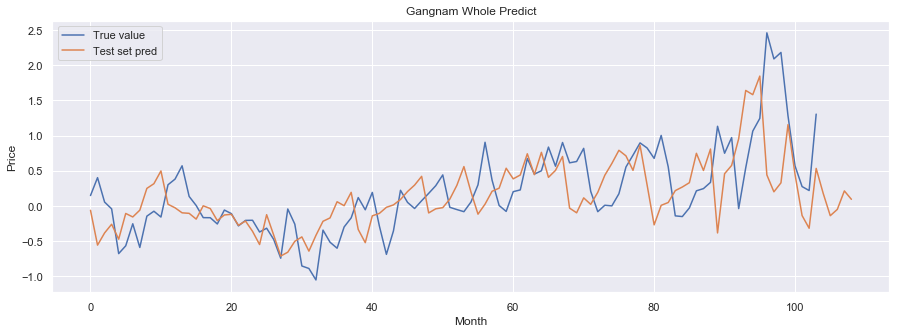

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71] TEST: [72 73 74 75 76 77 78 79 80]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 72 samples, validate on 9 samples
Epoch 1/2000
72/72 [==============================] - 5s 69ms/step - loss: 5.1359 - val_loss: 5.1238

Epoch 00001: val_loss improved from inf to 5.12385, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.123849.hdf5
Epoch 2/2000
72/72 [==============================] - 0s 3ms/step - loss: 4.9657 - val_loss: 4.9254

Epoch 00002: val_loss improved from 5.12385 to 4.92537, saving model to ./TimeSeries/LSTM/Gangnam-gu/v

72/72 [==============================] - 0s 2ms/step - loss: 1.7042 - val_loss: 1.6711

Epoch 00034: val_loss improved from 1.74162 to 1.67109, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.671087.hdf5
Epoch 35/2000
72/72 [==============================] - 0s 2ms/step - loss: 1.6344 - val_loss: 1.6020

Epoch 00035: val_loss improved from 1.67109 to 1.60201, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.602008.hdf5
Epoch 36/2000
72/72 [==============================] - 0s 2ms/step - loss: 1.5663 - val_loss: 1.5346

Epoch 00036: val_loss improved from 1.60201 to 1.53463, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.534630.hdf5
Epoch 37/2000
72/72 [==============================] - 0s 3ms/step - loss: 1.4997 - val_loss: 1.4688

Epoch 00037: val_loss improved from 1.53463 to 1.46877, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.468773.hdf5
Epoch 38/2000
72/72 [==============================] - 0s 2ms/step - loss: 1.4346 - val_loss: 1.4045

Epoch 00

72/72 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0410

Epoch 00070: val_loss improved from 0.06658 to 0.04104, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.041037.hdf5
Epoch 71/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0164

Epoch 00071: val_loss improved from 0.04104 to 0.01636, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.016363.hdf5
Epoch 72/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0101

Epoch 00072: val_loss improved from 0.01636 to 0.01012, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.010122.hdf5
Epoch 73/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0100

Epoch 00073: val_loss improved from 0.01012 to 0.01003, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.010027.hdf5
Epoch 74/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0101

Epoch 00

72/72 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0098

Epoch 00116: val_loss did not improve from 0.00976
Epoch 117/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0097

Epoch 00117: val_loss improved from 0.00976 to 0.00974, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.009740.hdf5
Epoch 118/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0097

Epoch 00118: val_loss improved from 0.00974 to 0.00972, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.009718.hdf5
Epoch 119/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0097

Epoch 00119: val_loss improved from 0.00972 to 0.00970, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.009696.hdf5
Epoch 120/2000
72/72 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0097

Epoch 00120: val_loss did not improve from 0.00970
Epoch 121/2000
72/72 [====


Epoch 00164: val_loss did not improve from 0.00920
Epoch 165/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0093

Epoch 00165: val_loss did not improve from 0.00920
Epoch 166/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0095

Epoch 00166: val_loss did not improve from 0.00920
Epoch 167/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0094

Epoch 00167: val_loss did not improve from 0.00920
Epoch 168/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0093

Epoch 00168: val_loss did not improve from 0.00920
Epoch 169/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0093

Epoch 00169: val_loss did not improve from 0.00920
Epoch 170/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0094

Epoch 00170: val_loss did not improve from 0.00920
Epoch 171/2000
72/72 [==

72/72 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0089

Epoch 00214: val_loss did not improve from 0.00878
Epoch 215/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0089

Epoch 00215: val_loss did not improve from 0.00878
Epoch 216/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0089

Epoch 00216: val_loss did not improve from 0.00878
Epoch 217/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0090

Epoch 00217: val_loss did not improve from 0.00878
Epoch 218/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0091

Epoch 00218: val_loss did not improve from 0.00878
Epoch 219/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0088

Epoch 00219: val_loss did not improve from 0.00878
Epoch 220/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0063 - val_lo

Epoch 264/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0087

Epoch 00264: val_loss did not improve from 0.00848
Epoch 265/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0088

Epoch 00265: val_loss did not improve from 0.00848
Epoch 266/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0085

Epoch 00266: val_loss did not improve from 0.00848
Epoch 267/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0085

Epoch 00267: val_loss improved from 0.00848 to 0.00846, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.008465.hdf5
Epoch 268/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0088

Epoch 00268: val_loss did not improve from 0.00846
Epoch 269/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0088

Epoch 00269: val_loss did not improve from 0.00846
Epo

72/72 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0083

Epoch 00315: val_loss did not improve from 0.00826
Epoch 316/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0084

Epoch 00316: val_loss did not improve from 0.00826
Epoch 317/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0083

Epoch 00317: val_loss did not improve from 0.00826
Epoch 318/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0086

Epoch 00318: val_loss did not improve from 0.00826
Epoch 319/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0082

Epoch 00319: val_loss improved from 0.00826 to 0.00821, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.008209.hdf5
Epoch 320/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0086

Epoch 00320: val_loss did not improve from 0.00821
Epoch 321/2000
72/

72/72 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0083

Epoch 00366: val_loss did not improve from 0.00802
Epoch 367/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0082

Epoch 00367: val_loss did not improve from 0.00802
Epoch 368/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0083

Epoch 00368: val_loss did not improve from 0.00802
Epoch 369/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0084

Epoch 00369: val_loss did not improve from 0.00802
Epoch 370/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0082

Epoch 00370: val_loss did not improve from 0.00802
Epoch 371/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0082

Epoch 00371: val_loss did not improve from 0.00802
Epoch 372/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0054 - val_lo

72/72 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0081

Epoch 00419: val_loss did not improve from 0.00796
Epoch 420/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0082

Epoch 00420: val_loss did not improve from 0.00796
Epoch 421/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0082

Epoch 00421: val_loss did not improve from 0.00796
Epoch 422/2000
72/72 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0082

Epoch 00422: val_loss did not improve from 0.00796
Epoch 423/2000
72/72 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0082

Epoch 00423: val_loss did not improve from 0.00796
Epoch 00423: early stopping


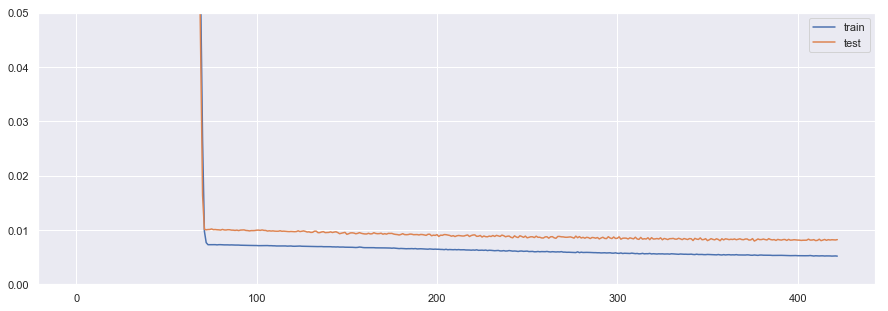

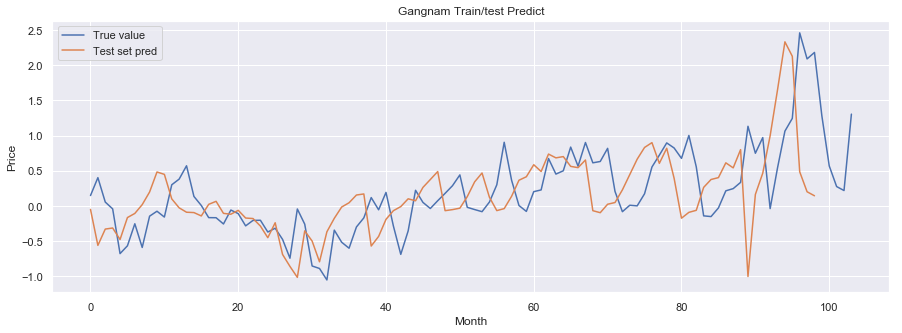

len before:  99
X shape:  (99,)
trans:  [2.1263254  0.48495921 0.20063792 0.14359017]
type:  <class 'numpy.ndarray'>
trans:  [[2.1263254 ]
 [0.48495921]
 [0.20063792]
 [0.14359017]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[2.1263254  0.48495921 0.20063792 0.14359017]]]
pred:  [[1.5558242]]
future_pred
[1.5558242]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[0.48495921 0.20063792 0.14359017 1.5558242 ]]
type:  <class 'numpy.ndarray'>
trans:  [[0.48495921]
 [0.20063792]
 [0.14359017]
 [1.5558242 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[0.48495921 0.20063792 0.14359017 1.5558242 ]]]
pred:  [[-0.53601825]]
future_pred
[-0.53601825]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[ 0.20063792  0.14359017  1.5558242  -0.53601825]]
type:  <class 'numpy.ndarray'>
trans:  [[ 0.20063792]
 [ 0.14359017]
 [ 1.5558242 ]
 [-0.53601825]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[ 0.200

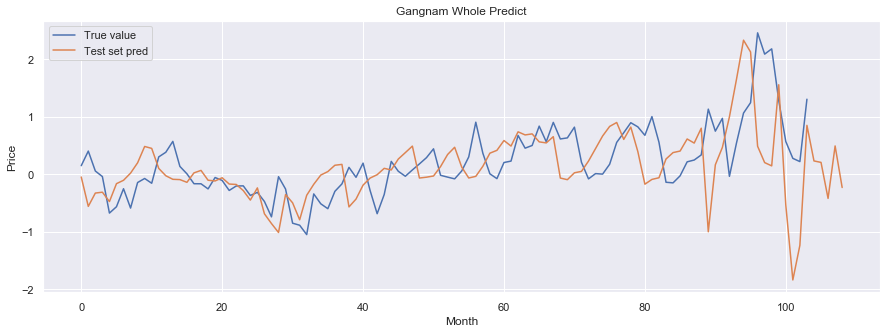

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80] TEST: [81 82 83 84 85 86 87 88 89]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 81 samples, validate on 9 samples
Epoch 1/2000
81/81 [==============================] - 4s 48ms/step - loss: 5.1286 - val_loss: 5.0637

Epoch 00001: val_loss improved from inf to 5.06375, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.063745.hdf5
Epoch 2/2000
81/81 [==============================] - 0s 2ms/step - loss: 4.9268 - val_loss: 4.8498

Epoch 00002: val_loss improved from 5.06375 to 4.84979, saving model to ./TimeSeries/LSTM/Gangnam-gu/v

81/81 [==============================] - 0s 2ms/step - loss: 1.3372 - val_loss: 1.3075

Epoch 00034: val_loss improved from 1.37962 to 1.30753, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.307533.hdf5
Epoch 35/2000
81/81 [==============================] - 0s 2ms/step - loss: 1.2659 - val_loss: 1.2374

Epoch 00035: val_loss improved from 1.30753 to 1.23738, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.237382.hdf5
Epoch 36/2000
81/81 [==============================] - 0s 2ms/step - loss: 1.1966 - val_loss: 1.1692

Epoch 00036: val_loss improved from 1.23738 to 1.16923, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.169232.hdf5
Epoch 37/2000
81/81 [==============================] - 0s 2ms/step - loss: 1.1293 - val_loss: 1.1030

Epoch 00037: val_loss improved from 1.16923 to 1.10305, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.103049.hdf5
Epoch 38/2000
81/81 [==============================] - 0s 2ms/step - loss: 1.0638 - val_loss: 1.0387

Epoch 00

81/81 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0190

Epoch 00072: val_loss did not improve from 0.01876
Epoch 73/2000
81/81 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0192

Epoch 00073: val_loss did not improve from 0.01876
Epoch 74/2000
81/81 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0193

Epoch 00074: val_loss did not improve from 0.01876
Epoch 75/2000
81/81 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0193

Epoch 00075: val_loss did not improve from 0.01876
Epoch 76/2000
81/81 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0193

Epoch 00076: val_loss did not improve from 0.01876
Epoch 77/2000
81/81 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0193

Epoch 00077: val_loss did not improve from 0.01876
Epoch 78/2000
81/81 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.

81/81 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0200

Epoch 00125: val_loss did not improve from 0.01876
Epoch 126/2000
81/81 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0198

Epoch 00126: val_loss did not improve from 0.01876
Epoch 127/2000
81/81 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0200

Epoch 00127: val_loss did not improve from 0.01876
Epoch 128/2000
81/81 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0200

Epoch 00128: val_loss did not improve from 0.01876
Epoch 129/2000
81/81 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0200

Epoch 00129: val_loss did not improve from 0.01876
Epoch 130/2000
81/81 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0198

Epoch 00130: val_loss did not improve from 0.01876
Epoch 131/2000
81/81 [==============================] - 0s 2ms/step - loss: 0.0071 - val_lo

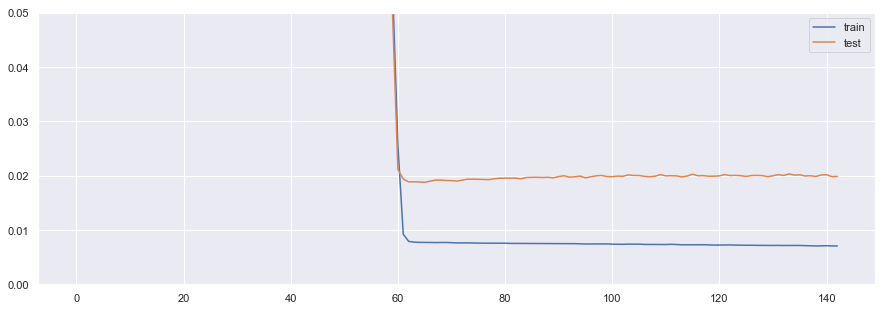

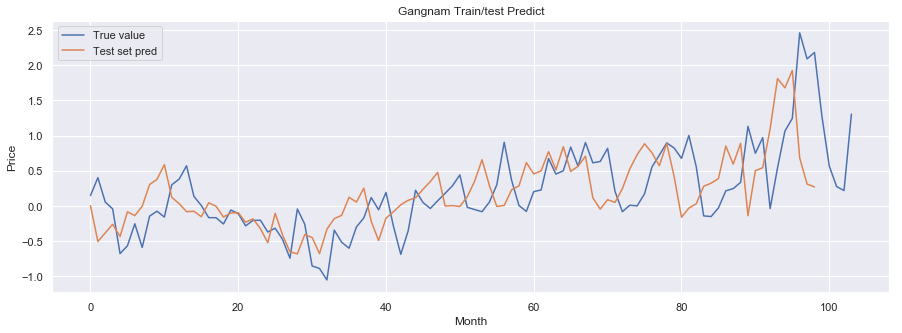

len before:  99
X shape:  (99,)
trans:  [1.9239498  0.6830372  0.31019422 0.26920727]
type:  <class 'numpy.ndarray'>
trans:  [[1.9239498 ]
 [0.6830372 ]
 [0.31019422]
 [0.26920727]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[1.9239498  0.6830372  0.31019422 0.26920727]]]
pred:  [[1.4683707]]
future_pred
[1.4683707]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[0.6830372  0.31019422 0.26920727 1.4683707 ]]
type:  <class 'numpy.ndarray'>
trans:  [[0.6830372 ]
 [0.31019422]
 [0.26920727]
 [1.4683707 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[0.6830372  0.31019422 0.26920727 1.4683707 ]]]
pred:  [[0.42728707]]
future_pred
[0.42728707]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[0.31019422 0.26920727 1.4683707  0.42728707]]
type:  <class 'numpy.ndarray'>
trans:  [[0.31019422]
 [0.26920727]
 [1.4683707 ]
 [0.42728707]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[0.31019422 0.269

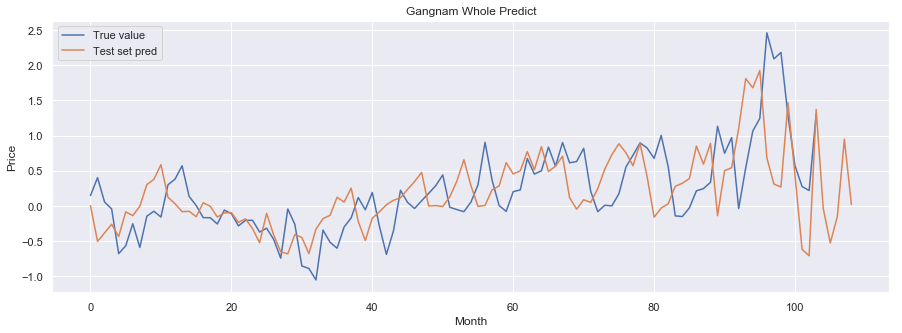

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89] TEST: [90 91 92 93 94 95 96 97 98]




/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 90 samples, validate on 9 samples
Epoch 1/2000
90/90 [==============================] - 6s 64ms/step - loss: 5.1241 - val_loss: 5.1903

Epoch 00001: val_loss improved from inf to 5.19027, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.190275.hdf5
Epoch 2/2000
90/90 [==============================] - 0s 2ms/step - loss: 4.9036 - val_loss: 4.8911

Epoch 00002: val_loss improved from 5.19027 to 4.89109, saving model to ./TimeSeries/LSTM/Gangnam-gu/v

90/90 [==============================] - 0s 3ms/step - loss: 1.1175 - val_loss: 1.1060

Epoch 00034: val_loss improved from 1.17858 to 1.10600, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.106004.hdf5
Epoch 35/2000
90/90 [==============================] - 0s 3ms/step - loss: 1.0464 - val_loss: 1.0357

Epoch 00035: val_loss improved from 1.10600 to 1.03573, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.035735.hdf5
Epoch 36/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.9774 - val_loss: 0.9676

Epoch 00036: val_loss improved from 1.03573 to 0.96760, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.967600.hdf5
Epoch 37/2000
90/90 [==============================] - 0s 3ms/step - loss: 0.9107 - val_loss: 0.9018

Epoch 00037: val_loss improved from 0.96760 to 0.90184, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.901845.hdf5
Epoch 38/2000
90/90 [==============================] - 0s 3ms/step - loss: 0.8463 - val_loss: 0.8382

Epoch 00

90/90 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0315

Epoch 00074: val_loss improved from 0.03157 to 0.03147, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.031467.hdf5
Epoch 75/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0315

Epoch 00075: val_loss did not improve from 0.03147
Epoch 76/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0315

Epoch 00076: val_loss did not improve from 0.03147
Epoch 77/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0315

Epoch 00077: val_loss did not improve from 0.03147
Epoch 78/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0315

Epoch 00078: val_loss did not improve from 0.03147
Epoch 79/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0315

Epoch 00079: val_loss did not improve from 0.03147
Epoch 80/2000
90/90 [==


Epoch 00125: val_loss did not improve from 0.03129
Epoch 126/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0318

Epoch 00126: val_loss did not improve from 0.03129
Epoch 127/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0318

Epoch 00127: val_loss did not improve from 0.03129
Epoch 128/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0317

Epoch 00128: val_loss did not improve from 0.03129
Epoch 129/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0321

Epoch 00129: val_loss did not improve from 0.03129
Epoch 130/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0319

Epoch 00130: val_loss did not improve from 0.03129
Epoch 131/2000
90/90 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0321

Epoch 00131: val_loss did not improve from 0.03129
Epoch 132/2000
90/90 [==

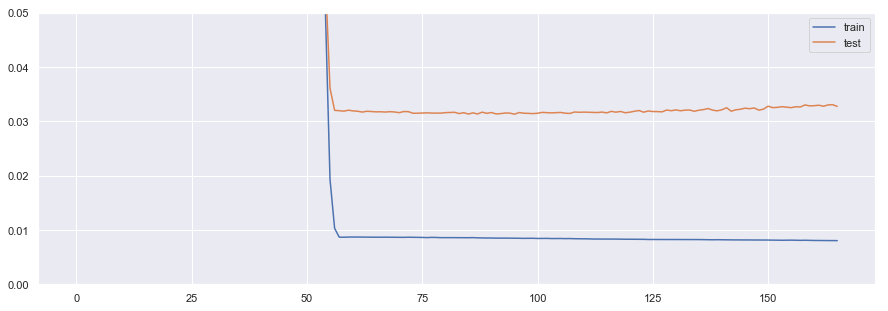

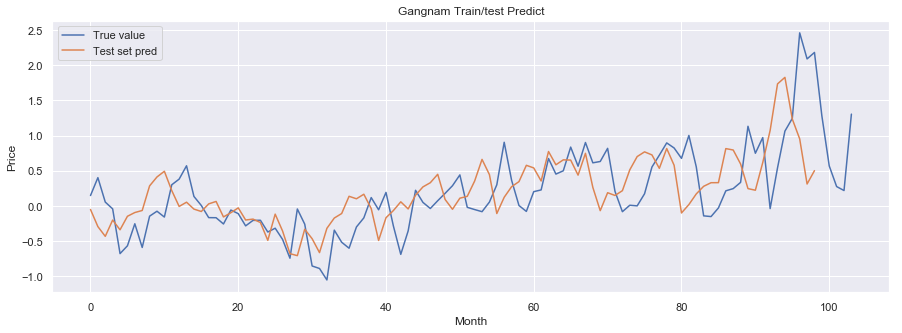

len before:  99
X shape:  (99,)
trans:  [1.2341418  0.95207286 0.3109855  0.5006409 ]
type:  <class 'numpy.ndarray'>
trans:  [[1.2341418 ]
 [0.95207286]
 [0.3109855 ]
 [0.5006409 ]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[1.2341418  0.95207286 0.3109855  0.5006409 ]]]
pred:  [[0.35239112]]
future_pred
[0.35239112]
(99,)
len before:  100
X shape:  (100, 1)
trans:  [[0.95207286 0.3109855  0.5006409  0.35239112]]
type:  <class 'numpy.ndarray'>
trans:  [[0.95207286]
 [0.3109855 ]
 [0.5006409 ]
 [0.35239112]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[0.95207286 0.3109855  0.5006409  0.35239112]]]
pred:  [[0.58591485]]
future_pred
[0.58591485]
(100, 1)
len before:  101
X shape:  (101, 1)
trans:  [[0.3109855  0.5006409  0.35239112 0.58591485]]
type:  <class 'numpy.ndarray'>
trans:  [[0.3109855 ]
 [0.5006409 ]
 [0.35239112]
 [0.58591485]]
trans shape:  (4, 1)
trans shape[0]:  4
trans shape[1]1:  1
tmp_shape:  [[[0.3109855  0.5

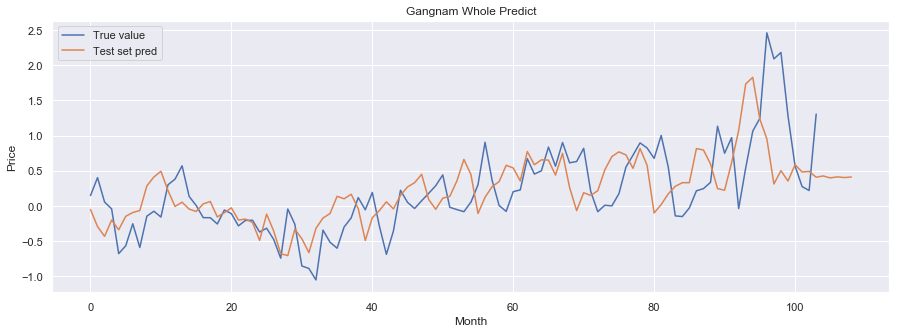

In [159]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("\n")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    model = Model(X_train, y_train, X_test, y_test, window_size)
    
    plt.figure(figsize = (15, 5))
    plt.plot(model[1].history['loss'], label='train')
    plt.plot(model[1].history['val_loss'], label='test')
    plt.ylim([0.0, 0.05])
    plt.legend()
    plt.show()
    
    reshaped_X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    pred = scaler.inverse_transform(model[0].predict(reshaped_X))
    orig_data = scaler.inverse_transform([y])
    
    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(pred[:, 0], label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()
    
    whole_predict = pred[:, 0]
    for i in range(10):
        future_pred = predict_future(model[0], whole_predict, window_size)
        whole_predict.shape = (whole_predict.size//1, 1)
        whole_predict = np.append(whole_predict, future_pred, axis=0)
        
    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(whole_predict, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Whole Predict")
    plt.legend()
    plt.show()

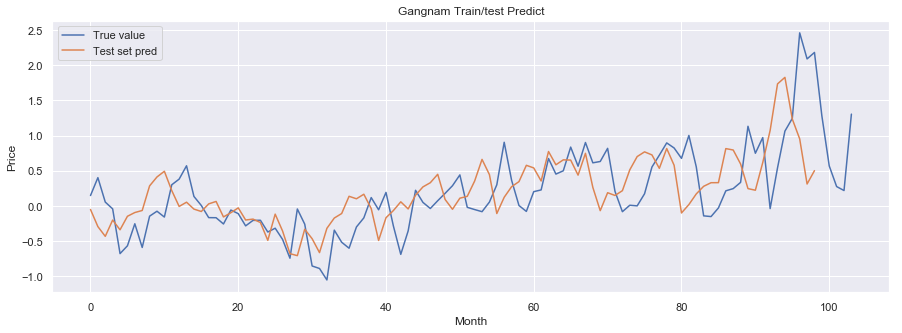

In [160]:
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(pred[:, 0], label = "Test set pred")
plt.xlabel("Month")
plt.ylabel("Price")
plt.title("Gangnam Train/test Predict")
plt.legend()
plt.show()

In [140]:
def predict_future(model, X, window_size):
    
    print('X shape: ', X.shape)
    
    trans = X[-window_size:].T
    print("trans: ", trans)
    print("type: ", type(trans))
    trans.shape = (trans.size//1, 1)
    print("trans: ", trans)
    print("trans shape: ", trans.shape)
    print("trans shape[0]: ", trans.shape[0])
    print("trans shape[1]1: ", trans.shape[1])
    
    tmp_shape = np.reshape(trans, (trans.shape[0], 1, trans.shape[1]))
    tmp_shape = tmp_shape.T
    print("tmp_shape: ", tmp_shape)
    pred = model.predict(tmp_shape)
    print("pred: ", pred)
    
#     print(pred[0])
    return pred

In [141]:
whole_predict = pred[:, 0]

In [211]:
test_predict_plot = np.empty_like(whole_predict)
print(len(test_predict_plot))
print(len(whole_predict))
test_predict_plot[:, :] = np.nan
test_predict_plot[:, :] = whole_predict

# test_predict_plot = np.insert(test_predict_plot, 0, np.nan, axis=1)

test_predict_plot = np.insert(test_predict_plot, 0, 0)

109
109


In [216]:
test_predict_plot = np.insert(test_predict_plot, 0, 0)

In [222]:
test_predict_plot = np.delete(test_predict_plot, 0)

In [223]:
print(len(test_predict_plot))

112


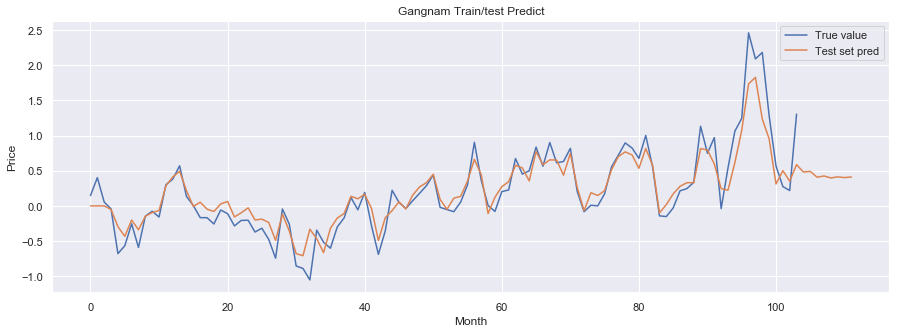

In [224]:
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(test_predict_plot, label = "Test set pred")
plt.xlabel("Month")
plt.ylabel("Price")
plt.title("Gangnam Train/test Predict")
plt.legend()
plt.show()

In [145]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
whole_X = np.reshape(whole_X, (whole_X.shape[0], 1, whole_X.shape[1]))

print("New training data shape:")
print(train_X.shape)

New training data shape:
(78, 1, 4)


In [54]:
MODEL_PATH = ''


if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

def create_checkpoint(model_name):
    global MODEL_PATH
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    print("Model_path : ", MODEL_PATH)
    
    MODEL_PATH = MODEL_PATH + "/" + GU_ENG_NAME
    
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.6f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

In [58]:
def Model(train_X, train_Y, test_X, test_Y, window_size = 1):
    model = Sequential()
#     model.add(LSTM(12,return_sequences=True, input_shape = (1, window_size)))
    model.add(LSTM ( 256,  activation = 'relu', inner_activation = 'hard_sigmoid' , bias_regularizer=L1L2(l1=0.01, l2=0.01),  input_shape =(1, window_size), return_sequences = False ))
#     model.add(LSTM(12,return_sequences=True))
#     model.add(LSTM(12))
    model.add(Dense(1))
    
#     adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    adam = Adam(lr=0.001, beta_1=0.89, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=True)
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    model.compile(loss = "mean_squared_error", 
                  optimizer = adam)

    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    history = model.fit(train_X, train_Y, epochs = 2000 ,batch_size=4, validation_data=(test_X, test_Y),
                        shuffle=False,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [ ]:
model = Model(train_X, train_Y, window_size)

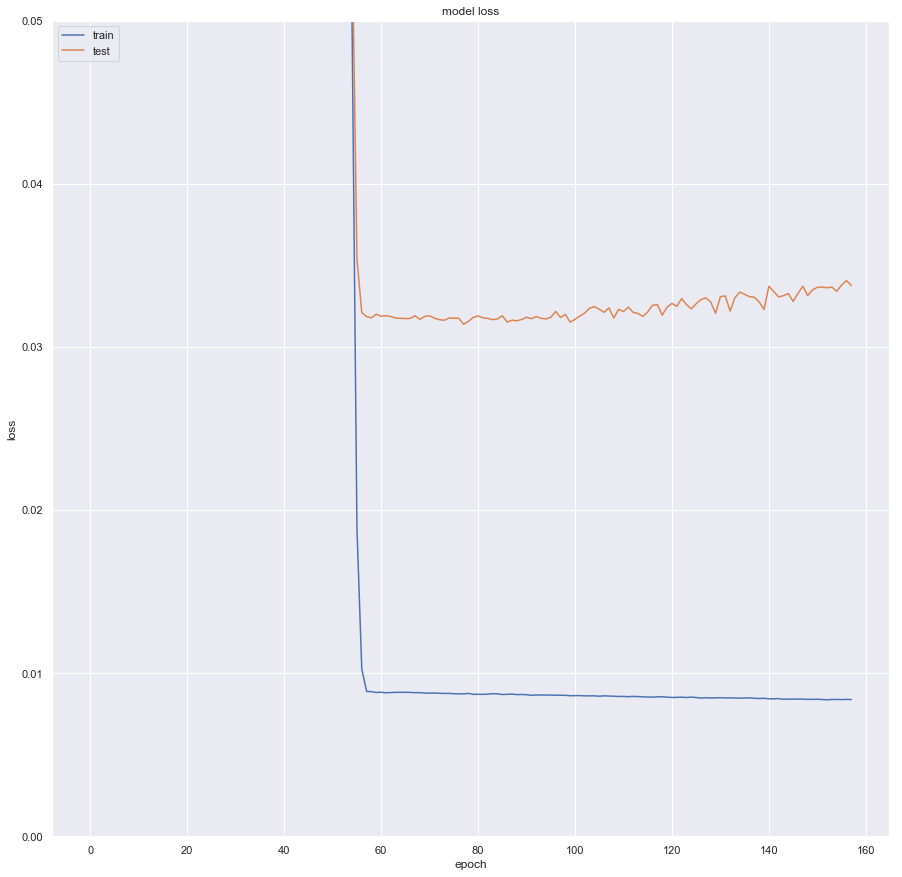

In [157]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
 
T=25
history_val_loss=[]
 
for x in model[1].history['val_loss']:
    if x >= T:
        history_val_loss.append (T)
    else:
        history_val_loss.append( x )
        
plt.figure(figsize = (15, 15))
plt.plot(model[1].history['loss'])
plt.plot(history_val_loss)
plt.ylim([0.0, 0.05])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [62]:
def predict_and_score(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    orig_data = scaler.inverse_transform([Y])
    
    print(len(orig_data[0]))
    print(len(pred[:, 0]))
    
    #RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred, orig_data)

In [63]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [ ]:
rmse_train, train_predict, train_orig = predict_and_score(model[0], train_X, train_Y)
rmse_test, test_predict, test_orig = predict_and_score(model[0], test_X, test_Y)

whole_test, whole_predict, whole_orig = predict_and_score(model[0], whole_X, whole_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
print("Whole data score: %.2f RMSE " % whole_test)

In [ ]:
mean_absolute_percentage_error(whole_orig[0], whole_predict[:, 0])

In [ ]:
def start_predict_n_plot(dataset, train_predict, test_predict):
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    
    ##땡기자
    print("window_size: ", window_size)
    train_predict_plot[(window_size - 1) : len(train_predict) + (window_size - 1)] = train_predict

    
    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
#     test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1] = test_predict
    test_predict_plot[(window_size - 1): len(whole_predict) + (window_size - 1), :] = whole_predict
    
    print(test_predict_plot.shape)
    print(whole_predict.shape)

    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(train_predict_plot, label = "Training set pred")
    plt.plot(test_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()

In [ ]:
start_predict_n_plot(dataset, train_predict, test_predict)

In [ ]:
len(train_X)

In [ ]:
len(whole_predict)

In [ ]:
whole_predict[-window_size:].shape

In [ ]:
whole_predict[-window_size:]

In [ ]:
def predict_future(model, X, window_size):
    
    print('X shape: ', X.shape)
    
    trans = X[-window_size:].T
    
    print("trans: ", trans)
    print("trans shape: ", trans.shape)
    
    
    tmp_shape = np.reshape(trans, (trans.shape[0], 1, trans.shape[1]))
    print("tmp_shape: ", tmp_shape)
    pred = model.predict(tmp_shape)
    print("pred: ", pred)
    
#     print(pred[0])
    return pred

In [ ]:
len(whole_predict)

In [ ]:
future_pred = predict_future(model[0], whole_predict, window_size)

In [ ]:
whole_predict = np.append(whole_predict, future_pred, axis=0)

In [ ]:
for i in range(10):
    print("len before: ", len(whole_predict))
    future_pred = predict_future(model[0], whole_predict, window_size)
    
    print("future_pred")
    print(future_pred)
    whole_predict = np.append(whole_predict, future_pred, axis=0)

In [ ]:
whole_predict

In [150]:
def whole_predict_n_plot(dataset, train_predict):
    
    true_value_plot = np.empty_like(dataset)
    print(true_value_plot.shape)
    print(whole_predict.shape)
    
    print('dataset_len : ', len(dataset))
    print('whole_predict_len : ', len(whole_predict))
    
    
#     test_predict_plot[:, :] = np.nan
#     test_predict_plot[(window_size - 1): len(whole_predict) + (window_size - 1), :] = whole_predict

    whole_predict_plot = np.empty_like(dataset)
    whole_predict_plot[:, :] = np.nan
    whole_predict_plot[3: len(whole_predict) - (window_size + 3), :] = whole_predict[: len(whole_predict) - (window_size + 6)]
    

    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(whole_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()

In [ ]:
whole_predict_n_plot(dataset, train_predict)

In [ ]:
whole_predict_n_plot(dataset, train_predict)

In [225]:
def get_best_weights_path():
    result = MODEL_PATH +"/"+sorted(os.listdir(MODEL_PATH))[0]

#     result = './TimeSeries/LSTM/Gangnam-gu/val_loss-0.006086.hdf5'
    print("best model path: ", result)
    
    return result

In [226]:
best_weights = get_best_weights_path()

best model path:  ./TimeSeries/LSTM/Gangnam-gu/.DS_Store


In [ ]:
model[0].load_weights(best_weights)

In [ ]:
def run_loaded_model(model, train_X, train_Y, window_size = 1):
#     adam = Adam(lr=0.00146, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    adam = Adam(lr=0.001, beta_1=0.89, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=True)
    model.compile(loss = "mean_squared_error", 
                  optimizer = adam)
    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    history = model.fit(train_X, train_Y, epochs = 1000 ,batch_size=4, validation_split = 0.2,
                        shuffle=True,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [ ]:
loaded_model = run_loaded_model(model[0], train_X, train_Y, window_size)

In [ ]:
def mape(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    orig_data = scaler.inverse_transform([Y])
    
    print(Y)
    
    Y, pred = np.array(Y), np.array(pred)
    
    return np.mean(np.abs((Y - pred) / Y) * 100)

In [ ]:
rmse_train_score, train_predict, train_orig = predict_and_score(loaded_model[0], train_X, train_Y)
rmse_test_score, test_predict, test_orig = predict_and_score(loaded_model[0], test_X, test_Y)

whole_test_score, whole_predict, whole_orig = predict_and_score(loaded_model[0], whole_X, whole_Y)


print(whole_X[:5])
print(whole_Y[:5])
print('\n')
print("Training data score: %.2f RMSE" % rmse_train_score)
print("Test data score: %.2f RMSE" % rmse_test_score)
print("Whole data score: %.2f RMSE " % whole_test_score)

In [ ]:
mape(loaded_model[0], whole_X, whole_Y)

In [ ]:
mean_absolute_percentage_error(whole_orig[0], whole_predict[:, 0])

In [ ]:
whole_predict = np.append(whole_predict, future_pred, axis=0)

In [ ]:
for i in range(10):
    print("len before: ", len(whole_predict))
    future_pred = predict_future(model[0], whole_predict, window_size)
    
    print("future_pred")
    print(future_pred)
    whole_predict = np.append(whole_predict, future_pred, axis=0)

In [ ]:
whole_predict_n_plot(dataset, train_predict)